# Setup environment

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pytz import timezone
import copy
import pathlib

from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

from src.lightgbm_wrapper.feature_engineer import add_time_features, add_lag_features, add_rolling_features
from src.lightgbm_wrapper.plot import plot_1_data, plot_2_data
from src.lightgbm_wrapper.model import build_supervised_for_horizon, train_test_validation_split, train_lgbm_for_horizon, plot_timeseries_example

try:
    import lightgbm as lgb
except:
    print("lightgbm is not installed")

DATA_DIR = "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/merged-data/by-station"
#STATION_IDS = [211, 212, 213, 214, 215, 216]
#STATION_IDS = [211, 212, 213, 214, 216]
STATION_IDS = [211, 212, 213, 216]

CMAQDATA_DIR = "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/concentration_station"

PM_COLS = [
    "NO2_quantrac",
    "PM25_quantrac",
    "O3_quantrac",
    "CO_quantrac",
    #"Temperature_quantrac",
    #"Humid_quantrac",
    "SO2_quantrac"
]

CMAQ_COLS = [
    "NO2_cmaq",
    "O3_cmaq",
    "SO2_cmaq"
]

BASE_FEATURE_COLS = PM_COLS + CMAQ_COLS

# Define lag and rolling windows for feature engineering
LAG_STEPS = [3, 6, 12, 24]
ROLL_WINDOWS = [3, 6, 12, 24]

# Define horizon (= n_past = n_future)
HORIZONS = [1, 24, 48, 72]

# Directory to save the results and meta data
LIGHTGBM_DIR = f"/le_thanh_van_118/workspace/hiep_workspace/lightgbm_results/{datetime.now(timezone('Asia/Saigon')).strftime('%Y_%m_%d-%H_%M_%S')}"
pathlib.Path(LIGHTGBM_DIR).mkdir(parents=True, exist_ok=True)
print(LIGHTGBM_DIR)
with open(os.path.join(LIGHTGBM_DIR, "CONFIGURATIONS.txt"), "w") as f:
    f.write(f"BASE_FEATURE_COLS: {BASE_FEATURE_COLS}\n")
    f.write(f"LAG_STEPS: {LAG_STEPS}\n")
    f.write(f"ROLL_WINDOWS: {ROLL_WINDOWS}\n")
    f.write(f"HORIZONS: {HORIZONS}\n")

/le_thanh_van_118/workspace/hiep_workspace/lightgbm_results/2025_12_19-23_30_55


# Load dataset

## Method

In [2]:
def load_station_csv(station_id, data_dir=DATA_DIR):
    csv_path = os.path.join(data_dir, f"{station_id}.csv")
    df = pd.read_csv(csv_path)

    # Convert to datetime
    if "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"])
    elif "Date" in df.columns and "Time" in df.columns:
        df["date"] = pd.to_datetime((df["Date"] + " " + df["Time"]).astype('datetime64[ns]'), format="%y/%m/%d %H:%M:%S")
        df = df.drop(columns=["Date", "Time"])
    df = df.sort_values("date").reset_index(drop=True)

    # Remove "Unnamed" column
    for c in df.columns:
        if "Unnamed:" in c:
            df = df.drop(columns=[c])

    # Add station_id column
    if "Station" not in df.columns:
        df["station_id"] = station_id
    else:
        df = df.rename({"Station": "station_id"}, axis=1)
    return df

## CMAQ data

In [3]:
# Load dataset
dfs_cmaq = []
for sid in STATION_IDS:
    df_sid = load_station_csv(sid, CMAQDATA_DIR)
    dfs_cmaq.append(df_sid)
df_cmaq = pd.concat(dfs_cmaq, ignore_index=True)

# Rename columns
df_cmaq = df_cmaq.rename({c: f"{c}_cmaq" for c in df_cmaq.columns if c not in ["date", "station_id"]}, axis=1)

# Sort data by station then date
df_cmaq = df_cmaq.sort_values(["station_id", "date"]).reset_index(drop=True)

# Remove uncessary features
df_cmaq = df_cmaq.loc[:, ["date"] + CMAQ_COLS + ["station_id"]]

display(df_cmaq)

# Convert unit
df_cmaq["NO2_cmaq"] = df_cmaq["NO2_cmaq"] * 1883.2
df_cmaq["O3_cmaq"] = df_cmaq["O3_cmaq"] * 1960
df_cmaq["SO2_cmaq"] = df_cmaq["SO2_cmaq"] * 2620

print(df_cmaq.shape)
print(df_cmaq.columns)
df_cmaq

,date,NO2_cmaq,O3_cmaq,SO2_cmaq,station_id
0,2022-01-01 07:00:00,0.000072,0.096425,0.000027,211
1,2022-01-01 08:00:00,0.000074,0.077419,0.000038,211
2,2022-01-01 09:00:00,0.000055,0.061006,0.000050,211
3,2022-01-01 10:00:00,0.000040,0.048525,0.000057,211
4,2022-01-01 11:00:00,0.000034,0.029449,0.000047,211
...,...,...,...,...,...
29899,2022-12-31 01:00:00,0.002276,0.026421,0.000149,216
29900,2022-12-31 02:00:00,0.002208,0.026171,0.000148,216
29901,2022-12-31 03:00:00,0.002249,0.026087,0.000151,216
29902,2022-12-31 04:00:00,0.002680,0.026347,0.000166,216


(29904, 5)
Index(['date', 'NO2_cmaq', 'O3_cmaq', 'SO2_cmaq', 'station_id'], dtype='object')


,date,NO2_cmaq,O3_cmaq,SO2_cmaq,station_id
0,2022-01-01 07:00:00,0.136344,188.993157,0.071526,211
1,2022-01-01 08:00:00,0.138604,151.741122,0.100084,211
2,2022-01-01 09:00:00,0.104141,119.571595,0.130476,211
3,2022-01-01 10:00:00,0.075893,95.109490,0.149078,211
4,2022-01-01 11:00:00,0.063087,57.721016,0.122092,211
...,...,...,...,...,...
29899,2022-12-31 01:00:00,4.285888,51.784937,0.389183,216
29900,2022-12-31 02:00:00,4.157322,51.295325,0.386550,216
29901,2022-12-31 03:00:00,4.235773,51.130547,0.394695,216
29902,2022-12-31 04:00:00,5.047855,51.640614,0.435544,216


## PM data

In [4]:
# Load dataset
dfs_pm = []
for sid in STATION_IDS:
    df_sid = load_station_csv(sid, DATA_DIR)
    dfs_pm.append(df_sid)
df_pm = pd.concat(dfs_pm, ignore_index=True)

# Sort data by station then date
df_pm = df_pm.sort_values(["station_id", "date"]).reset_index(drop=True)

# Remove uncessary features
df_pm = df_pm.loc[:, ["date"] + PM_COLS + ["station_id"]]

print(df_pm.shape)
print(df_pm.columns)
df_pm

(61139, 7)
Index(['date', 'NO2_quantrac', 'PM25_quantrac', 'O3_quantrac', 'CO_quantrac',
       'SO2_quantrac', 'station_id'],
      dtype='object')


,date,NO2_quantrac,PM25_quantrac,O3_quantrac,CO_quantrac,SO2_quantrac,station_id
0,2021-02-23 21:00:00,112.740762,15.604762,55.431381,90.000000,NaN,211
1,2021-02-23 22:00:00,112.366471,14.594118,58.197176,1200.603529,NaN,211
2,2021-02-23 23:00:00,112.700433,13.436667,55.029433,1177.897000,NaN,211
3,2021-02-24 00:00:00,112.480867,12.365000,54.767700,90.000000,NaN,211
4,2021-02-24 01:00:00,114.331500,11.636667,53.786200,90.000000,NaN,211
...,...,...,...,...,...,...,...
61134,2022-12-31 19:00:00,0.088233,41.450000,75.916667,2.087167,0.105667,216
61135,2022-12-31 20:00:00,0.083217,50.530000,66.116667,2.006500,0.104167,216
61136,2022-12-31 21:00:00,0.084300,55.055000,55.133333,2.418833,0.130167,216
61137,2022-12-31 22:00:00,0.066650,26.078333,46.750000,1.481500,0.075833,216


## Merge 2 data

In [5]:
dfs_all = []
for station in STATION_IDS:
    df_pm_station = df_pm[df_pm["station_id"] == station]
    df_cmaq_station = df_cmaq[df_cmaq["station_id"] == station]
    df_joined = pd.merge(df_pm_station.drop(columns=["station_id"]), df_cmaq_station, on='date', how='inner')
    dfs_all.append(df_joined)
df_all = pd.concat(dfs_all, axis=0).reset_index(drop=True)
df_all

,date,NO2_quantrac,PM25_quantrac,O3_quantrac,CO_quantrac,SO2_quantrac,NO2_cmaq,O3_cmaq,SO2_cmaq,station_id
0,2022-01-01 07:00:00,90.000000,22.783333,35.588975,756.627400,NaN,0.136344,188.993157,0.071526,211
1,2022-01-01 08:00:00,90.000000,21.883333,55.011077,749.102000,NaN,0.138604,151.741122,0.100084,211
2,2022-01-01 09:00:00,90.000000,16.233333,64.729197,727.519000,NaN,0.104141,119.571595,0.130476,211
3,2022-01-01 10:00:00,90.000000,15.700000,75.109218,721.196900,NaN,0.075893,95.109490,0.149078,211
4,2022-01-01 11:00:00,74.207348,15.650000,77.767804,722.056400,NaN,0.063087,57.721016,0.122092,211
...,...,...,...,...,...,...,...,...,...,...
28588,2022-12-31 01:00:00,0.049037,17.709259,31.425926,0.824074,0.031852,4.285888,51.784937,0.389183,216
28589,2022-12-31 02:00:00,0.063288,22.803390,43.220339,0.717627,0.024746,4.157322,51.295325,0.386550,216
28590,2022-12-31 03:00:00,0.069050,23.031667,48.866667,0.746167,0.026167,4.235773,51.130547,0.394695,216
28591,2022-12-31 04:00:00,0.064600,22.331667,50.633333,0.617667,0.020333,5.047855,51.640614,0.435544,216


In [6]:
df_all.isnull().sum()

date                 0
NO2_quantrac     20359
PM25_quantrac    20359
O3_quantrac      20358
CO_quantrac      20358
SO2_quantrac     21911
NO2_cmaq             0
O3_cmaq              0
SO2_cmaq             0
station_id           0
dtype: int64

# Data preparation

## Drop missing

Output: df_dropped

In [7]:
df_dropped = df_all.dropna().reset_index(drop=True)
df_dropped

,date,NO2_quantrac,PM25_quantrac,O3_quantrac,CO_quantrac,SO2_quantrac,NO2_cmaq,O3_cmaq,SO2_cmaq,station_id
0,2022-01-01 07:00:00,0.081167,24.380000,60.100000,1.716167,0.100833,1.847962,192.197659,0.202002,216
1,2022-01-01 08:00:00,0.080950,22.648333,63.233333,2.143833,0.128833,2.436309,156.783693,0.274170,216
2,2022-01-01 09:00:00,0.077917,22.331667,66.700000,2.194833,0.132833,1.949658,125.387982,0.345334,216
3,2022-01-01 10:00:00,0.067467,24.293333,71.166667,1.860500,0.103667,1.540650,103.125890,0.342248,216
4,2022-01-01 11:00:00,0.038431,24.360345,53.982759,1.923966,0.124655,1.142447,86.564792,0.235276,216
...,...,...,...,...,...,...,...,...,...,...
6675,2022-12-31 01:00:00,0.049037,17.709259,31.425926,0.824074,0.031852,4.285888,51.784937,0.389183,216
6676,2022-12-31 02:00:00,0.063288,22.803390,43.220339,0.717627,0.024746,4.157322,51.295325,0.386550,216
6677,2022-12-31 03:00:00,0.069050,23.031667,48.866667,0.746167,0.026167,4.235773,51.130547,0.394695,216
6678,2022-12-31 04:00:00,0.064600,22.331667,50.633333,0.617667,0.020333,5.047855,51.640614,0.435544,216


## Update the STATION_IDS after dropping missing

In [8]:
STATION_IDS = list(df_dropped["station_id"].unique())
STATION_IDS

[216]

## Visualization

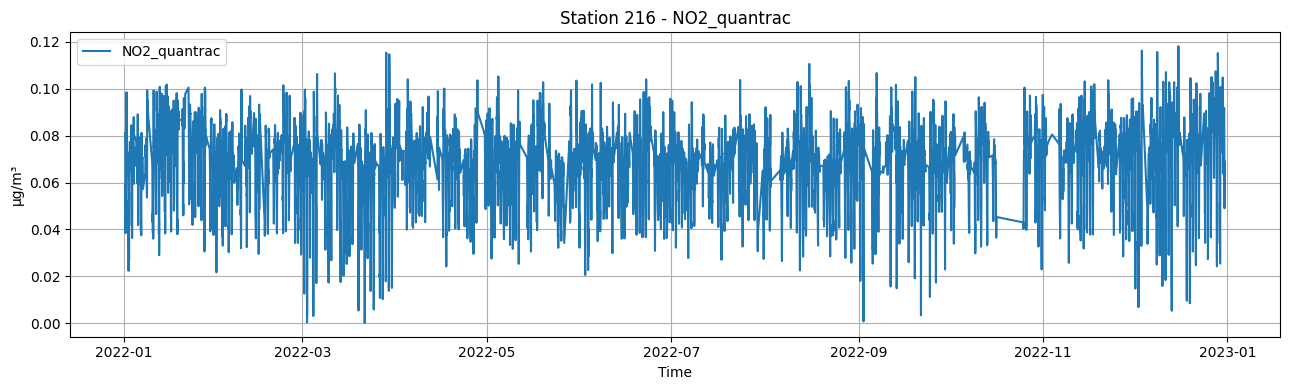

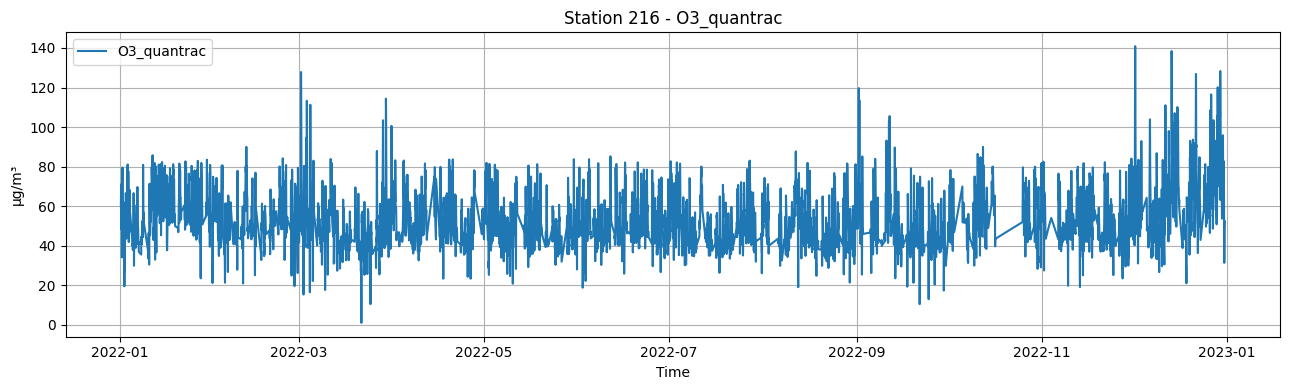

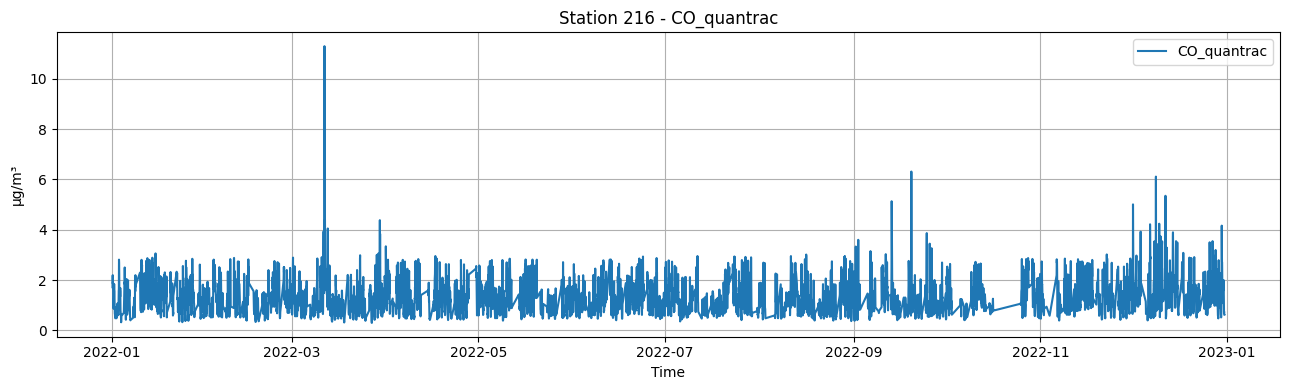

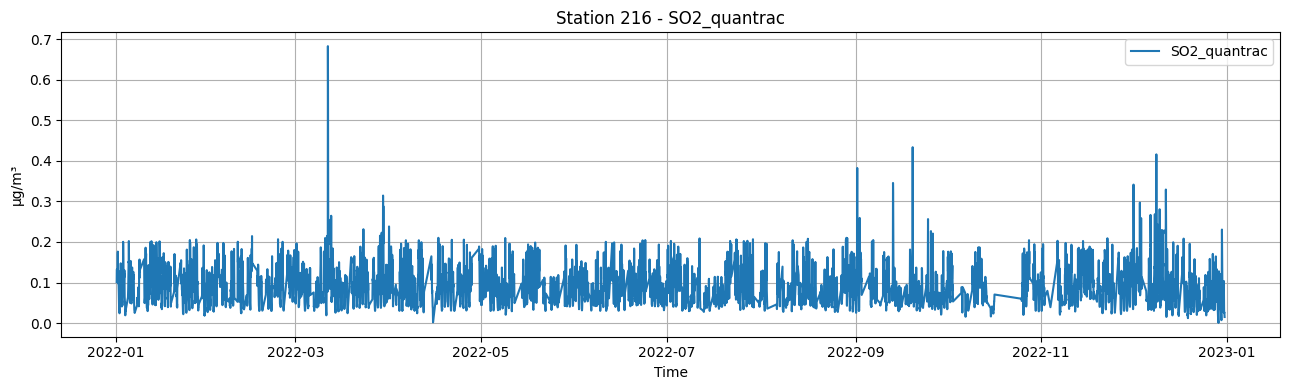

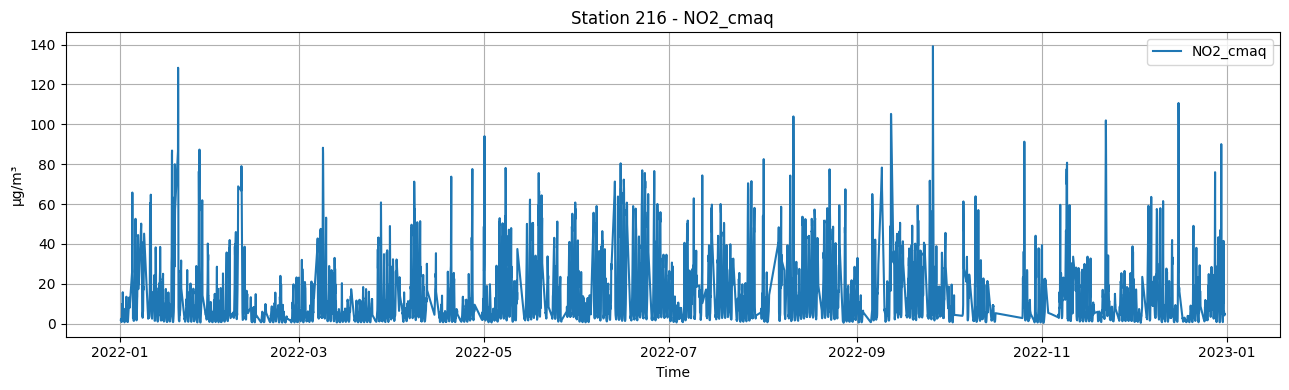

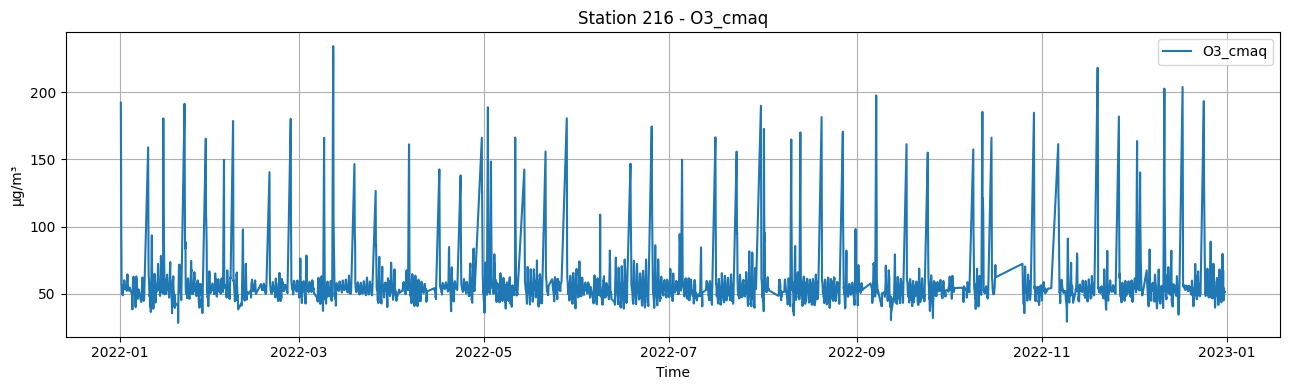

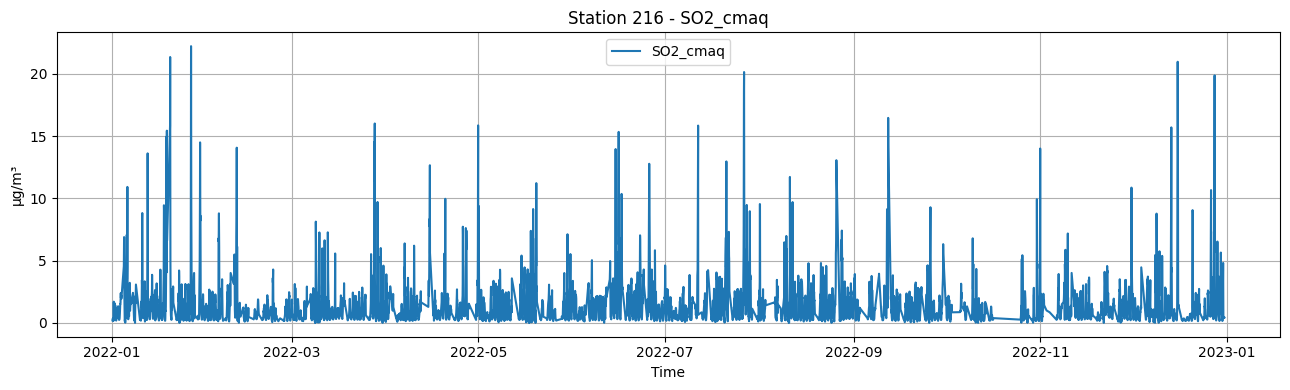

In [9]:
for station in STATION_IDS:
    df_station = df_dropped[df_dropped["station_id"] == station]
    for target_col in df_station.columns:
        if target_col not in ["date", "station_id", "Temperature_quantrac", "Humid_quantrac", "PM25_quantrac"]:
            plot_1_data(df_station, target_col, target_col, df_station["date"], f"Station {station} - {target_col}")
            #plot_1_data(df_station, target_col, target_col, df_station.index, f"Station {station} - {target_col}")
    print("\n" + "=" * 150 + "\n")

## Convert ppm to ug/m3

Apply only to station 216, year 2022 on NO2, CO columns

Output: df_converted

In [10]:
df_converted = copy.deepcopy(df_dropped)
#mask = (df_converted["station_id"] == 216) & (df_converted["date"] >= "2022-01-01")

print("=" * 50 + "BEFORE" + "=" * 50)
for station in STATION_IDS:
    display(df_converted[df_converted["station_id"] == station])

#mask_no2 = (df_converted["NO2_quantrac"] < 1.0)
#df_converted.loc[mask_no2, "NO2_quantrac"] = df_converted.loc[mask_no2, "NO2_quantrac"].apply(lambda x: x * 1883.2)
df_converted.loc[:, "NO2_quantrac"] = df_converted.loc[:, "NO2_quantrac"].apply(lambda x: x * 1883.2)

#mask_co = (df_converted["CO_quantrac"] < 1.0)
#df_converted.loc[mask_co, "CO_quantrac"] = df_converted.loc[mask_co, "CO_quantrac"].apply(lambda x: x * 1146.8)
df_converted.loc[:, "CO_quantrac"] = df_converted.loc[:, "CO_quantrac"].apply(lambda x: x * 1146.8)

#mask_so2 = (df_converted["SO2_quantrac"] < 1.0)
#df_converted.loc[mask_so2, "SO2_quantrac"] = df_converted.loc[mask_so2, "SO2_quantrac"].apply(lambda x: x * 2620)
df_converted.loc[:, "SO2_quantrac"] = df_converted.loc[:, "SO2_quantrac"].apply(lambda x: x * 2620)

print("=" * 50 + "AFTER" + "=" * 50)
for station in STATION_IDS:
    display(df_converted[df_converted["station_id"] == station])

'''
df_converted = copy.deepcopy(df_dropped)
mask = (df_converted["station_id"] == 216) & (df_converted["date"] >= "2022-01-01")
df_converted.loc[mask, "NO2_quantrac"] = df_converted.loc[mask, "NO2_quantrac"].apply(lambda x: x * 1883.2)
df_converted.loc[mask, "CO_quantrac"] = df_converted.loc[mask, "CO_quantrac"].apply(lambda x: x * 1146.8)
df_converted.loc[mask, "SO2_quantrac"] = df_converted.loc[mask, "SO2_quantrac"].apply(lambda x: x * 2620)
df_converted.loc[mask, "SO2_cmaq"] = df_converted.loc[mask, "SO2_cmaq"].apply(lambda x: x * 2620)
df_converted
'''

==================================================BEFORE==================================================


,date,NO2_quantrac,PM25_quantrac,O3_quantrac,CO_quantrac,SO2_quantrac,NO2_cmaq,O3_cmaq,SO2_cmaq,station_id
0,2022-01-01 07:00:00,0.081167,24.380000,60.100000,1.716167,0.100833,1.847962,192.197659,0.202002,216
1,2022-01-01 08:00:00,0.080950,22.648333,63.233333,2.143833,0.128833,2.436309,156.783693,0.274170,216
2,2022-01-01 09:00:00,0.077917,22.331667,66.700000,2.194833,0.132833,1.949658,125.387982,0.345334,216
3,2022-01-01 10:00:00,0.067467,24.293333,71.166667,1.860500,0.103667,1.540650,103.125890,0.342248,216
4,2022-01-01 11:00:00,0.038431,24.360345,53.982759,1.923966,0.124655,1.142447,86.564792,0.235276,216
...,...,...,...,...,...,...,...,...,...,...
6675,2022-12-31 01:00:00,0.049037,17.709259,31.425926,0.824074,0.031852,4.285888,51.784937,0.389183,216
6676,2022-12-31 02:00:00,0.063288,22.803390,43.220339,0.717627,0.024746,4.157322,51.295325,0.386550,216
6677,2022-12-31 03:00:00,0.069050,23.031667,48.866667,0.746167,0.026167,4.235773,51.130547,0.394695,216
6678,2022-12-31 04:00:00,0.064600,22.331667,50.633333,0.617667,0.020333,5.047855,51.640614,0.435544,216


==================================================AFTER==================================================


,date,NO2_quantrac,PM25_quantrac,O3_quantrac,CO_quantrac,SO2_quantrac,NO2_cmaq,O3_cmaq,SO2_cmaq,station_id
0,2022-01-01 07:00:00,152.853067,24.380000,60.100000,1968.099933,264.183333,1.847962,192.197659,0.202002,216
1,2022-01-01 08:00:00,152.445040,22.648333,63.233333,2458.548067,337.543333,2.436309,156.783693,0.274170,216
2,2022-01-01 09:00:00,146.732667,22.331667,66.700000,2517.034867,348.023333,1.949658,125.387982,0.345334,216
3,2022-01-01 10:00:00,127.053227,24.293333,71.166667,2133.621400,271.606667,1.540650,103.125890,0.342248,216
4,2022-01-01 11:00:00,72.373324,24.360345,53.982759,2206.403655,326.596552,1.142447,86.564792,0.235276,216
...,...,...,...,...,...,...,...,...,...,...
6675,2022-12-31 01:00:00,92.346548,17.709259,31.425926,945.048148,83.451852,4.285888,51.784937,0.389183,216
6676,2022-12-31 02:00:00,119.184217,22.803390,43.220339,822.974780,64.833898,4.157322,51.295325,0.386550,216
6677,2022-12-31 03:00:00,130.034960,23.031667,48.866667,855.703933,68.556667,4.235773,51.130547,0.394695,216
6678,2022-12-31 04:00:00,121.654720,22.331667,50.633333,708.340133,53.273333,5.047855,51.640614,0.435544,216


'\ndf_converted = copy.deepcopy(df_dropped)\nmask = (df_converted["station_id"] == 216) & (df_converted["date"] >= "2022-01-01")\ndf_converted.loc[mask, "NO2_quantrac"] = df_converted.loc[mask, "NO2_quantrac"].apply(lambda x: x * 1883.2)\ndf_converted.loc[mask, "CO_quantrac"] = df_converted.loc[mask, "CO_quantrac"].apply(lambda x: x * 1146.8)\ndf_converted.loc[mask, "SO2_quantrac"] = df_converted.loc[mask, "SO2_quantrac"].apply(lambda x: x * 2620)\ndf_converted.loc[mask, "SO2_cmaq"] = df_converted.loc[mask, "SO2_cmaq"].apply(lambda x: x * 2620)\ndf_converted\n'

## Visualization after converting unit

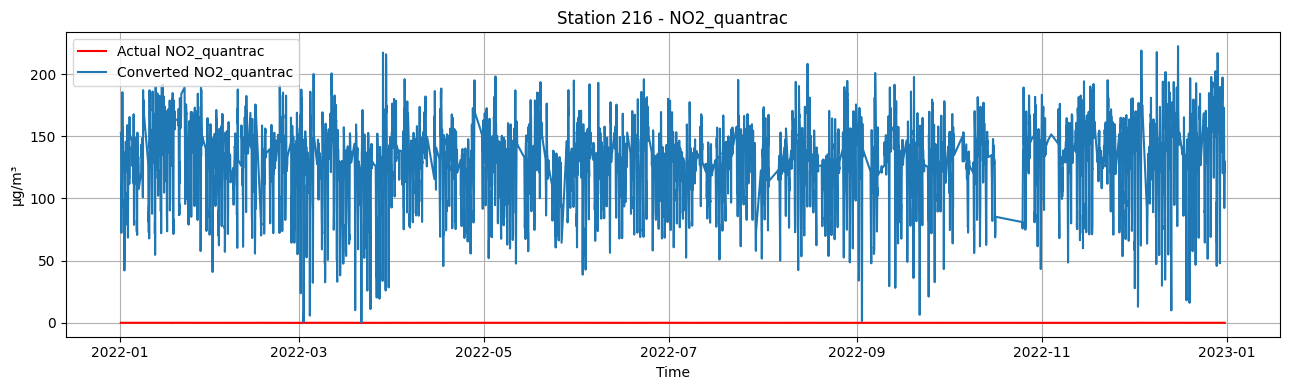

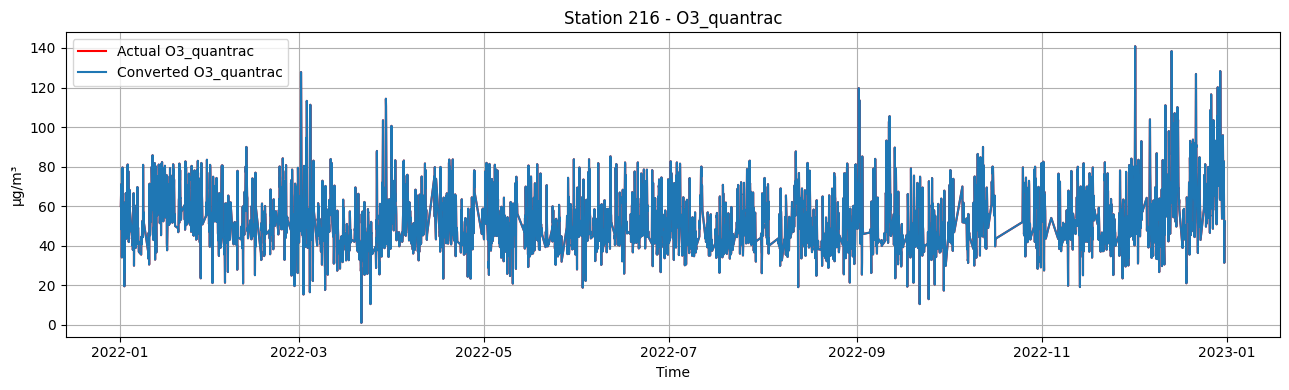

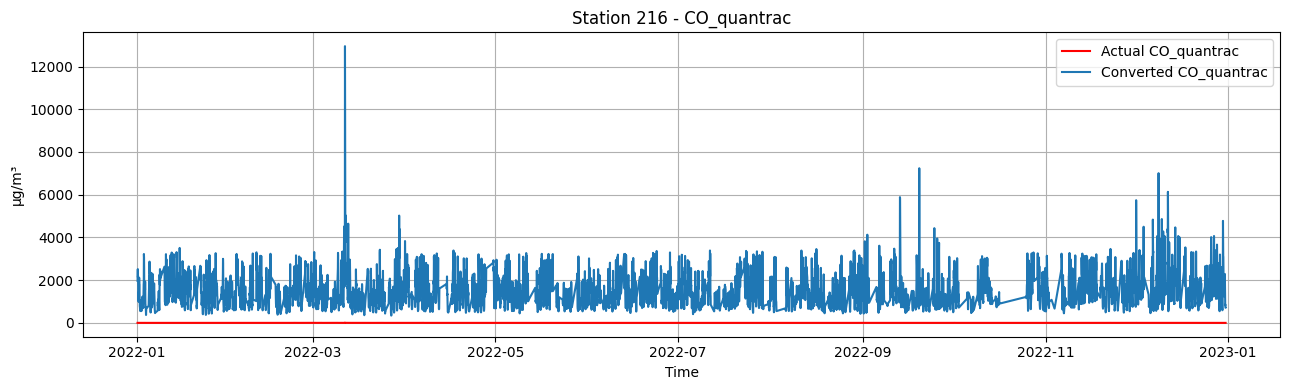

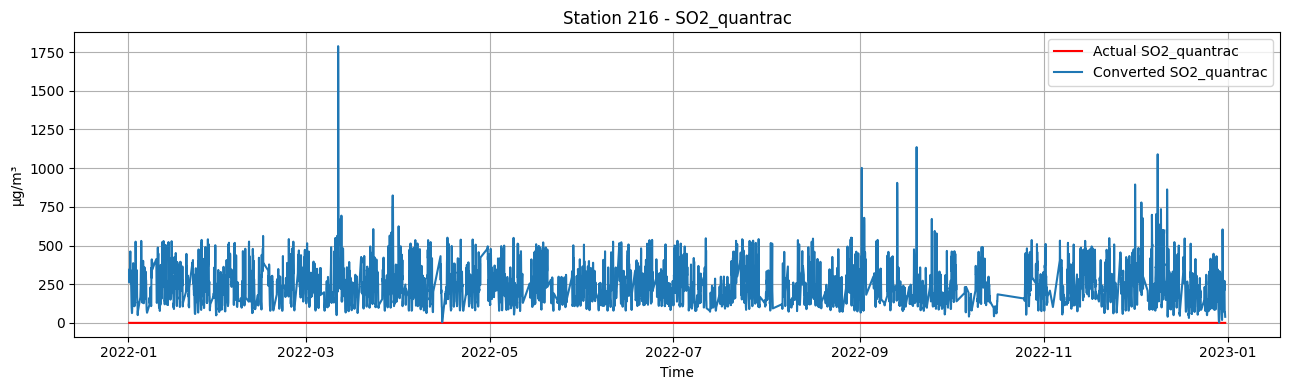

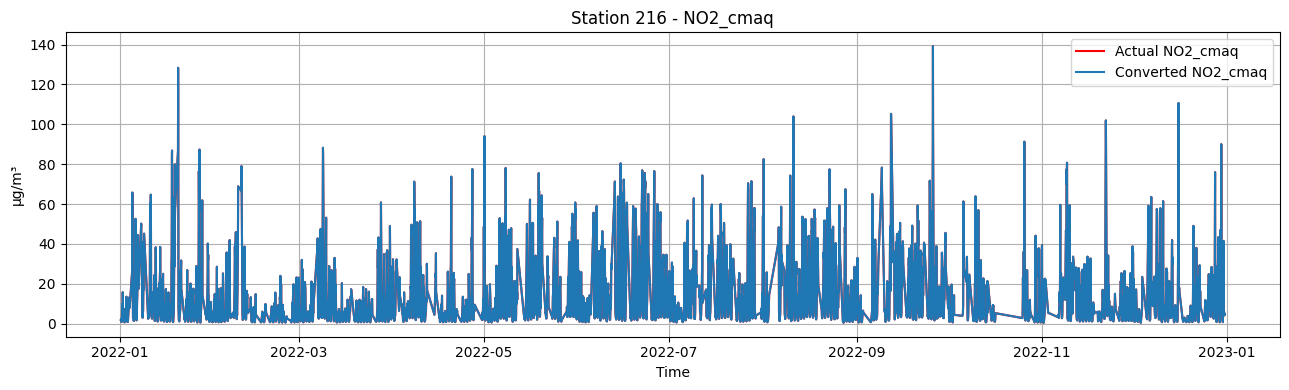

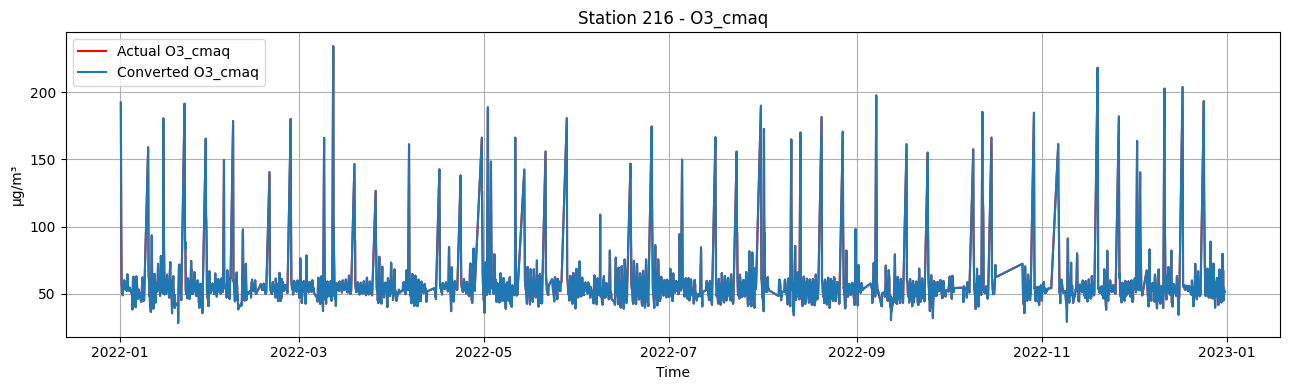

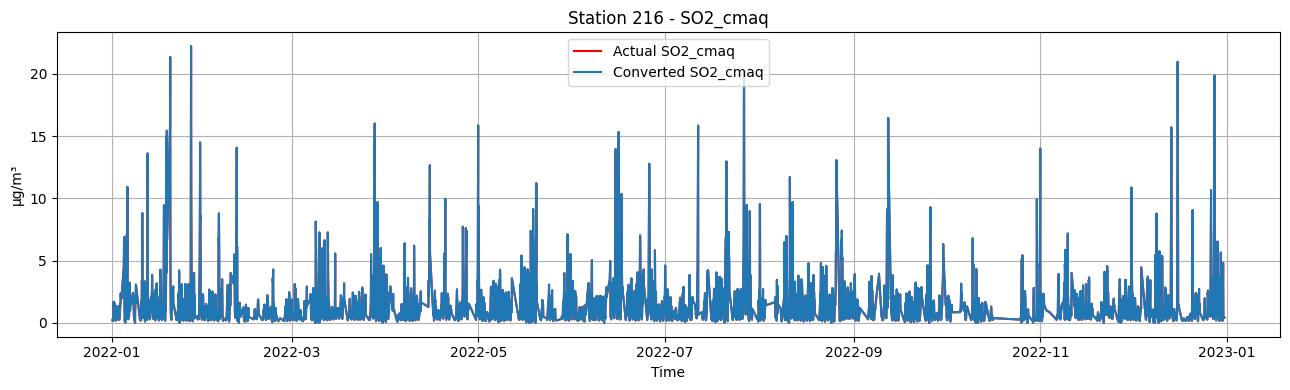

In [11]:
for station in STATION_IDS:
    df_station = df_dropped[df_dropped["station_id"] == station]
    df_station_converted = df_converted[df_converted["station_id"] == station]
    for target_col in df_station.columns:
        if target_col not in ["date", "station_id", "Temperature_quantrac", "Humid_quantrac", "PM25_quantrac"]:
            plot_2_data(df_station, target_col, f"Actual {target_col}",
                        df_station_converted, target_col, f"Converted {target_col}",
                        df_station["date"], f"Station {station} - {target_col}")
                        #df_station.index, f"Station {station} - {target_col}")
    print("\n" + "=" * 150 + "\n")

## Ugly hack to remove outliers

In [12]:
test = copy.deepcopy(df_converted)

lenbefore = len(test)
print(f"Before: {lenbefore} records")

# Since we only have 1 station, we don't need to query for each station

# 216 CO quantrac
#test = test.drop(index=test[test["CO_quantrac"] > 6000].index)
#test = test.drop(index=test[test["SO2_quantrac"] > 6000].index)
#test = test.drop(index=test[test["NO2_cmaq"] > 100].index)

# 216 SO2 quantrac
test216 = test[test["station_id"] == 216]
#test = test.drop(index=test216[test216["SO2_quantrac"] > 700].index, errors="ignore")
test = test.drop(index=test216[test216["SO2_quantrac"] > 500].index, errors="ignore")
test = test.drop(index=test216[test216["O3_quantrac"] > 120].index, errors="ignore")
test = test.drop(index=test216[test216["NO2_cmaq"] > 80].index, errors="ignore")
test = test.drop(index=test216[test216["O3_cmaq"] > 200].index, errors="ignore")
#test = test.drop(index=test216[test216["O3_cmaq"] > 100].index, errors="ignore")
test = test.drop(index=test216[test216["SO2_cmaq"] > 40000].index, errors="ignore")
#test = test.drop(index=test216[test216["SO2_cmaq"] > 1000].index, errors="ignore")

lenafter = len(test)
print(f"After: {lenafter} records")
print(f"Removed {lenbefore - lenafter} records")

df_converted = test.reset_index(drop=True)

Before: 6680 records
After: 6482 records
Removed 198 records


## Visualization after removing outliers

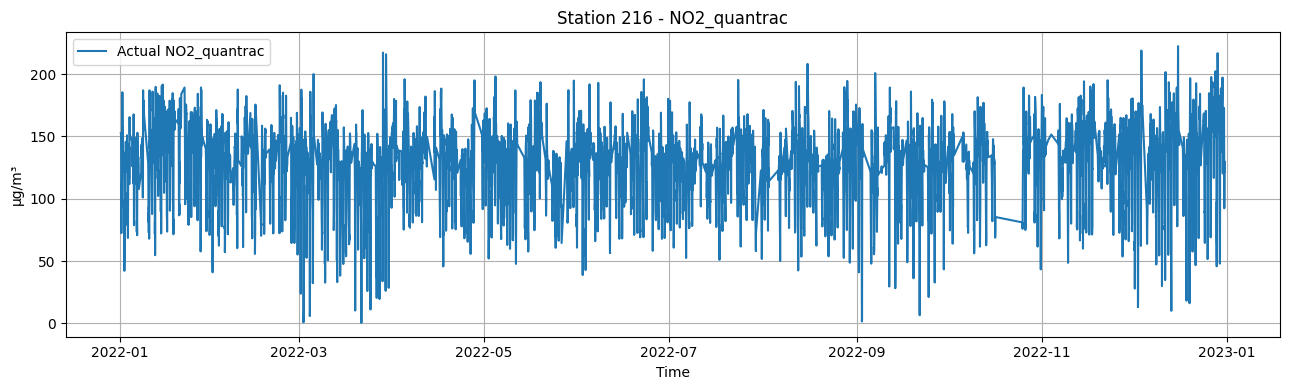

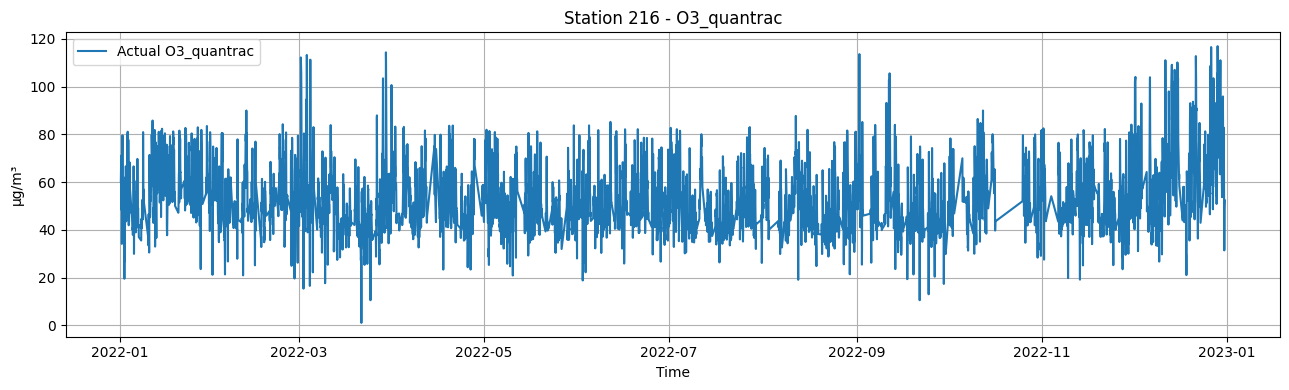

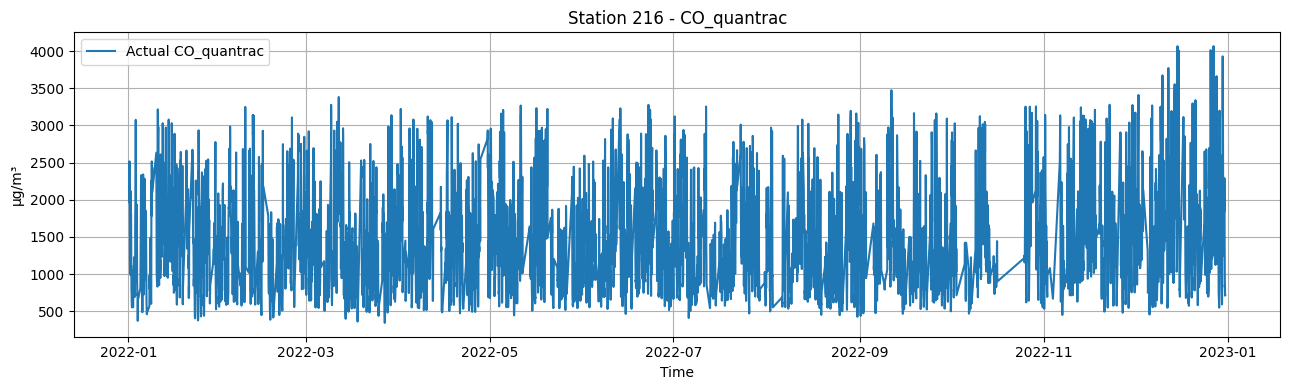

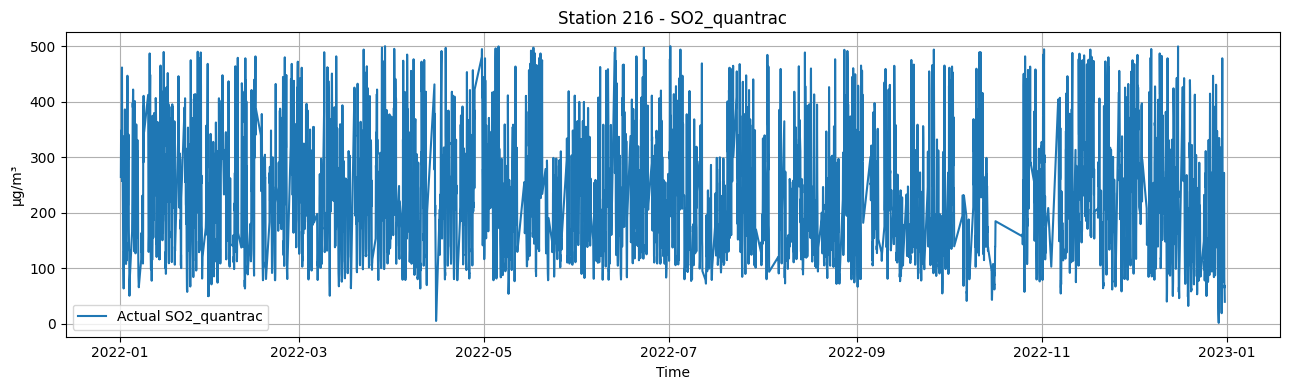

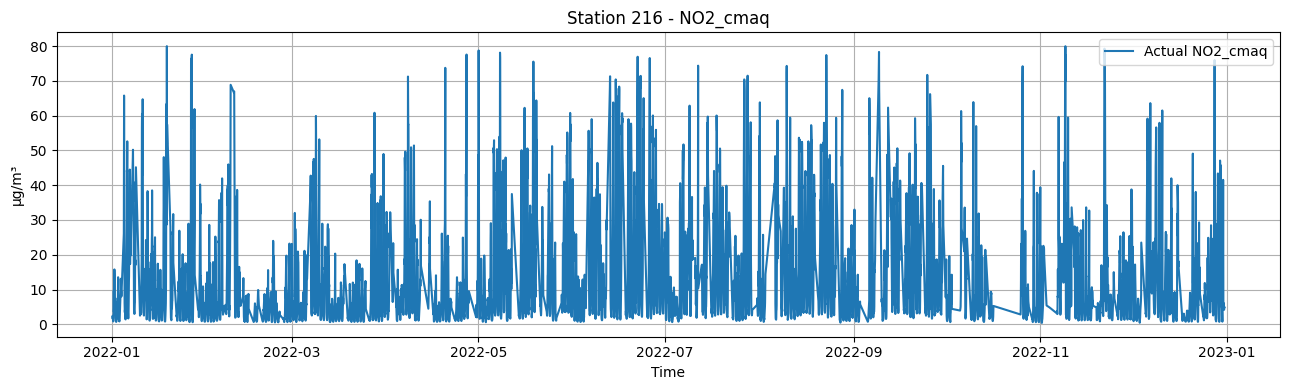

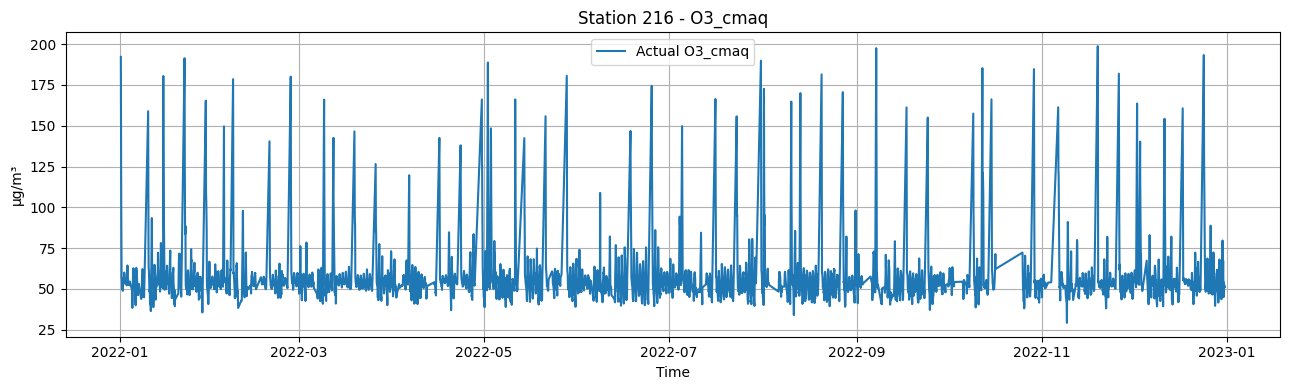

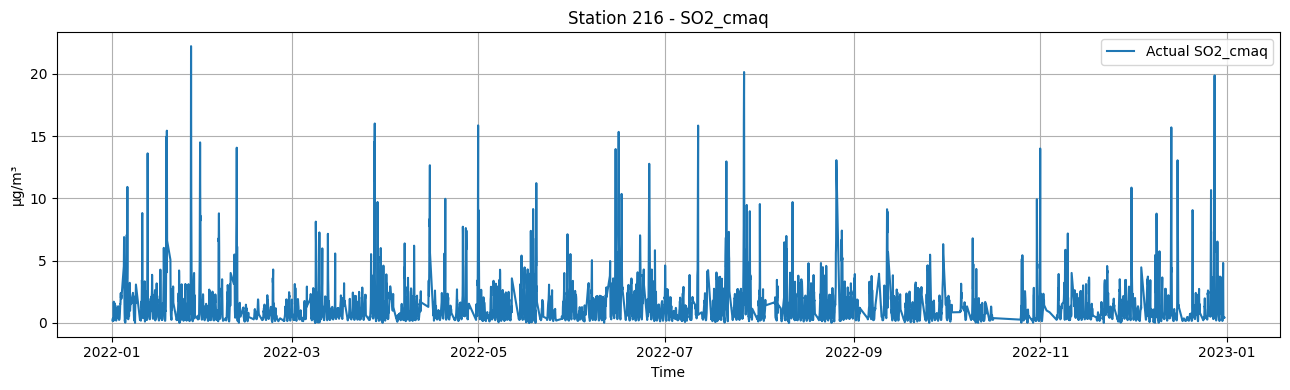

In [13]:
for station in STATION_IDS:
    df_station = df_converted[df_converted["station_id"] == station]
    for target_col in df_station.columns:
        if target_col not in ["date", "station_id", "Temperature_quantrac", "Humid_quantrac", "PM25_quantrac"]:
            plot_1_data(df_station, target_col, f"Actual {target_col}",
                        df_station["date"], f"Station {station} - {target_col}")
                        #df_station.index, f"Station {station} - {target_col}")
    print("\n" + "=" * 150 + "\n")

## Feature engineering

In [14]:
# Add time features and lag feature for all gases
dftestno2 = add_time_features(df_converted)
dftestno2 = add_lag_features(df_converted, group_col="station_id", target_cols=BASE_FEATURE_COLS, lag_steps=[3, 6, 12, 24])
dftestno2 = add_rolling_features(df_converted, group_col="station_id", target_cols=["NO2_quantrac"], windows=[3, 6, 12, 24])
print(dftestno2.shape)
print(dftestno2.columns)
dftestno2

(6482, 18)
Index(['date', 'NO2_quantrac', 'PM25_quantrac', 'O3_quantrac', 'CO_quantrac',
       'SO2_quantrac', 'NO2_cmaq', 'O3_cmaq', 'SO2_cmaq', 'station_id',
       'NO2_quantrac_roll3_mean', 'NO2_quantrac_roll3_std',
       'NO2_quantrac_roll6_mean', 'NO2_quantrac_roll6_std',
       'NO2_quantrac_roll12_mean', 'NO2_quantrac_roll12_std',
       'NO2_quantrac_roll24_mean', 'NO2_quantrac_roll24_std'],
      dtype='object')


,date,NO2_quantrac,PM25_quantrac,O3_quantrac,CO_quantrac,SO2_quantrac,NO2_cmaq,O3_cmaq,SO2_cmaq,station_id,NO2_quantrac_roll3_mean,NO2_quantrac_roll3_std,NO2_quantrac_roll6_mean,NO2_quantrac_roll6_std,NO2_quantrac_roll12_mean,NO2_quantrac_roll12_std,NO2_quantrac_roll24_mean,NO2_quantrac_roll24_std
0,2022-01-01 07:00:00,152.853067,24.380000,60.100000,1968.099933,264.183333,1.847962,192.197659,0.202002,216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-01-01 08:00:00,152.445040,22.648333,63.233333,2458.548067,337.543333,2.436309,156.783693,0.274170,216,152.853067,NaN,152.853067,NaN,152.853067,NaN,152.853067,NaN
2,2022-01-01 09:00:00,146.732667,22.331667,66.700000,2517.034867,348.023333,1.949658,125.387982,0.345334,216,152.649053,0.288518,152.649053,0.288518,152.649053,0.288518,152.649053,0.288518
3,2022-01-01 10:00:00,127.053227,24.293333,71.166667,2133.621400,271.606667,1.540650,103.125890,0.342248,216,150.676924,3.421914,150.676924,3.421914,150.676924,3.421914,150.676924,3.421914
4,2022-01-01 11:00:00,72.373324,24.360345,53.982759,2206.403655,326.596552,1.142447,86.564792,0.235276,216,142.076978,13.320759,144.771000,12.137797,144.771000,12.137797,144.771000,12.137797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6477,2022-12-31 01:00:00,92.346548,17.709259,31.425926,945.048148,83.451852,4.285888,51.784937,0.389183,216,162.467849,16.160517,167.076458,11.438594,151.443282,20.588002,158.321706,21.591192
6478,2022-12-31 02:00:00,119.184217,22.803390,43.220339,822.974780,64.833898,4.157322,51.295325,0.386550,216,136.126298,40.487158,154.120158,32.318802,149.118635,25.435481,154.385585,24.575739
6479,2022-12-31 03:00:00,130.034960,23.031667,48.866667,855.703933,68.556667,4.235773,51.130547,0.394695,216,118.448157,25.741473,145.145079,33.472296,146.514295,26.848976,152.194126,25.291842
6480,2022-12-31 04:00:00,121.654720,22.331667,50.633333,708.340133,53.273333,5.047855,51.640614,0.435544,216,113.855242,19.401097,138.161545,31.048054,145.117588,27.265733,151.678042,25.624122


## Build supervised from time-series

In [15]:
# Example
Xdummy, ydummy = build_supervised_for_horizon(dftestno2, horizon_h=72, target_col="NO2_quantrac")
print("Horizon 1h:", Xdummy.shape, ydummy.shape)
print(Xdummy.columns)
print(ydummy.columns)
display(Xdummy)
display(ydummy)

Horizon 1h: (6408, 17) (6408, 3)
Index(['date', 'station_id', 'PM25_quantrac', 'O3_quantrac', 'CO_quantrac',
       'SO2_quantrac', 'NO2_cmaq', 'O3_cmaq', 'SO2_cmaq',
       'NO2_quantrac_roll3_mean', 'NO2_quantrac_roll3_std',
       'NO2_quantrac_roll6_mean', 'NO2_quantrac_roll6_std',
       'NO2_quantrac_roll12_mean', 'NO2_quantrac_roll12_std',
       'NO2_quantrac_roll24_mean', 'NO2_quantrac_roll24_std'],
      dtype='object')
Index(['date', 'station_id', 'NO2_quantrac_t_plus_72h'], dtype='object')


,date,station_id,PM25_quantrac,O3_quantrac,CO_quantrac,SO2_quantrac,NO2_cmaq,O3_cmaq,SO2_cmaq,NO2_quantrac_roll3_mean,NO2_quantrac_roll3_std,NO2_quantrac_roll6_mean,NO2_quantrac_roll6_std,NO2_quantrac_roll12_mean,NO2_quantrac_roll12_std,NO2_quantrac_roll24_mean,NO2_quantrac_roll24_std
0,2022-01-01 09:00:00,216,22.331667,66.700000,2517.034867,348.023333,1.949658,125.387982,0.345334,152.649053,0.288518,152.649053,0.288518,152.649053,0.288518,152.649053,0.288518
1,2022-01-01 10:00:00,216,24.293333,71.166667,2133.621400,271.606667,1.540650,103.125890,0.342248,150.676924,3.421914,150.676924,3.421914,150.676924,3.421914,150.676924,3.421914
2,2022-01-01 11:00:00,216,24.360345,53.982759,2206.403655,326.596552,1.142447,86.564792,0.235276,142.076978,13.320759,144.771000,12.137797,144.771000,12.137797,144.771000,12.137797
3,2022-01-01 12:00:00,216,22.908333,48.333333,1527.728733,292.566667,0.817503,63.247973,0.170824,115.386406,38.528093,130.291465,34.040847,130.291465,34.040847,130.291465,34.040847
4,2022-01-01 13:00:00,216,28.223333,70.116667,1153.489667,271.606667,0.832625,56.665207,0.159558,95.843693,28.149493,123.260309,34.980657,123.260309,34.980657,123.260309,34.980657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6403,2022-12-27 19:00:00,216,35.258333,76.116667,2450.138200,274.226667,20.748646,48.384501,7.332667,150.352596,1.813197,134.889431,17.120760,146.745744,20.652320,162.495435,23.113819
6404,2022-12-27 20:00:00,216,41.721667,78.383333,2186.183067,249.336667,21.971180,48.457658,6.862372,153.606347,5.044668,141.700338,17.311978,147.198236,20.876815,161.738232,22.904347
6405,2022-12-27 21:00:00,216,50.540000,70.883333,3397.203867,390.816667,22.201322,48.504896,5.678386,158.042329,8.308302,149.881796,14.481914,146.949758,20.613264,161.508063,22.831964
6406,2022-12-27 22:00:00,216,53.945000,68.000000,3267.424333,367.236667,34.812875,46.893053,10.498039,167.803582,9.859727,159.078089,11.470041,146.732667,20.230706,162.210340,23.094946


,date,station_id,NO2_quantrac_t_plus_72h
0,2022-01-01 09:00:00,216,140.926133
1,2022-01-01 10:00:00,216,140.831973
2,2022-01-01 11:00:00,216,135.150987
3,2022-01-01 12:00:00,216,139.639280
4,2022-01-01 13:00:00,216,140.110080
...,...,...,...
6403,2022-12-27 19:00:00,216,92.346548
6404,2022-12-27 20:00:00,216,119.184217
6405,2022-12-27 21:00:00,216,130.034960
6406,2022-12-27 22:00:00,216,121.654720


## Split train/validation/test for each station

In [16]:
# Example
(X_train_dummy, y_train_dummy, meta_train_dummy,
 X_val_dummy, y_val_dummy, meta_val_dummy,
 X_test_dummy, y_test_dummy, meta_test_dummy) = train_test_validation_split(Xdummy, ydummy)
display(X_test_dummy)

,PM25_quantrac,O3_quantrac,CO_quantrac,SO2_quantrac,NO2_cmaq,O3_cmaq,SO2_cmaq,NO2_quantrac_roll3_mean,NO2_quantrac_roll3_std,NO2_quantrac_roll6_mean,NO2_quantrac_roll6_std,NO2_quantrac_roll12_mean,NO2_quantrac_roll12_std,NO2_quantrac_roll24_mean,NO2_quantrac_roll24_std
5446,12.130000,41.216667,893.930600,130.126667,2.745542,58.682725,0.277592,109.602240,7.828378,110.711236,5.149505,116.564731,8.005307,117.370283,27.085799
5447,12.660000,43.066667,794.923533,120.083333,2.801622,58.083938,0.296794,103.942178,6.034272,108.540324,6.637472,113.718466,7.323562,116.921716,27.292664
5448,15.193333,46.916667,853.410333,131.436667,3.145434,57.455693,0.316692,100.186240,0.900420,106.447880,7.226755,111.900655,7.925114,117.283970,26.988204
5449,13.881667,41.400000,823.593533,130.563333,3.862728,56.039538,0.353362,102.906418,5.609029,106.254329,7.109719,111.064611,7.582089,118.191568,26.304148
5450,15.848333,49.350000,1171.838467,181.653333,6.091291,54.250556,0.442450,103.513227,5.178229,103.727702,5.034461,109.479309,7.395704,119.129887,25.226689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6403,35.258333,76.116667,2450.138200,274.226667,20.748646,48.384501,7.332667,150.352596,1.813197,134.889431,17.120760,146.745744,20.652320,162.495435,23.113819
6404,41.721667,78.383333,2186.183067,249.336667,21.971180,48.457658,6.862372,153.606347,5.044668,141.700338,17.311978,147.198236,20.876815,161.738232,22.904347
6405,50.540000,70.883333,3397.203867,390.816667,22.201322,48.504896,5.678386,158.042329,8.308302,149.881796,14.481914,146.949758,20.613264,161.508063,22.831964
6406,53.945000,68.000000,3267.424333,367.236667,34.812875,46.893053,10.498039,167.803582,9.859727,159.078089,11.470041,146.732667,20.230706,162.210340,23.094946


# LightGBM model

## Define model

## Add time and lags features

In [17]:
# Add time features and lag feature for all gases
df_time_feats = add_time_features(df_converted)
df_lag_feats = add_lag_features(df_time_feats, group_col="station_id", target_cols=BASE_FEATURE_COLS, lag_steps=LAG_STEPS)

## Training for SO2

In [18]:
label = "SO2_quantrac"

# Add rolling features for LABEL
df_so2 = add_rolling_features(df_lag_feats, group_col="station_id", target_cols=[label], windows=ROLL_WINDOWS)

# Start running model
so2_all_metrics = []
so2_models_by_h = {}
for h in HORIZONS:
    print(f"\n===== Training LightGBM for horizon = {h}h, target_col = {label} =====")
    model_h, metrics_overall, metrics_by_station, _ = train_lgbm_for_horizon(df_so2, horizon_h=h, target_col=label, calibrate=True, learning_rate=0.01)
    so2_models_by_h[h] = model_h
    model_h.save_model(os.path.join(LIGHTGBM_DIR, f"{label}_lightgbm_{h}h"))
    print("Overall test metrics:", metrics_overall)
    so2_all_metrics.append(metrics_by_station)

# Metrics table
so2_df_metrics_all = pd.concat(so2_all_metrics, ignore_index=True)
so2_df_metrics_all = so2_df_metrics_all.sort_values(["station", "horizon_h"]).reset_index(drop=True)
so2_df_metrics_all.to_csv(os.path.join(LIGHTGBM_DIR, f"{label}_metrics.csv"), index=False)
so2_df_metrics_all


===== Training LightGBM for horizon = 1h, target_col = SO2_quantrac =====

X.shape = (6457, 52)
y.shape = (6457, 3)

Number of features: 52

Features:
date
station_id
NO2_quantrac
PM25_quantrac
O3_quantrac
CO_quantrac
NO2_cmaq
O3_cmaq
SO2_cmaq
hour
dayofweek
month
NO2_quantrac_lag3
NO2_quantrac_lag6
NO2_quantrac_lag12
NO2_quantrac_lag24
PM25_quantrac_lag3
PM25_quantrac_lag6
PM25_quantrac_lag12
PM25_quantrac_lag24
O3_quantrac_lag3
O3_quantrac_lag6
O3_quantrac_lag12
O3_quantrac_lag24
CO_quantrac_lag3
CO_quantrac_lag6
CO_quantrac_lag12
CO_quantrac_lag24
SO2_quantrac_lag3
SO2_quantrac_lag6
SO2_quantrac_lag12
SO2_quantrac_lag24
NO2_cmaq_lag3
NO2_cmaq_lag6
NO2_cmaq_lag12
NO2_cmaq_lag24
O3_cmaq_lag3
O3_cmaq_lag6
O3_cmaq_lag12
O3_cmaq_lag24
SO2_cmaq_lag3
SO2_cmaq_lag6
SO2_cmaq_lag12
SO2_cmaq_lag24
SO2_quantrac_roll3_mean
SO2_quantrac_roll3_std
SO2_quantrac_roll6_mean
SO2_quantrac_roll6_std
SO2_quantrac_roll12_mean
SO2_quantrac_roll12_std
SO2_quantrac_roll24_mean
SO2_quantrac_roll24_std

Label

array([[308.6113702 ],
       [313.74175682],
       [262.47662965],
       [142.72285629],
       [132.753795  ],
       [188.60069693],
       [175.19599463],
       [157.82987715],
       [177.0189341 ],
       [243.09299532],
       [183.84544645],
       [142.66680398],
       [101.94533761],
       [134.35962979],
       [200.09552587],
       [329.42843914],
       [328.23697706],
       [317.04017431],
       [271.44375882],
       [194.90479952],
       [202.5852478 ],
       [161.37214659],
       [175.53918171],
       [229.3818695 ],
       [256.54678578],
       [270.89751894],
       [200.87931065],
       [259.31639061],
       [252.09670369],
       [238.10253037],
       [198.07258617],
       [187.99562168],
       [199.29439133],
       [148.27666309],
       [259.97877254],
       [283.69740005],
       [285.51673451],
       [311.02822081],
       [315.58859855],
       [345.13641317],
       [367.12123525],
       [338.10907226],
       [328.30123267],
       [292

[hiepdebug]  y_pred_corr...


array([[293.27051482],
       [298.86150783],
       [242.99379466],
       [112.48852079],
       [101.62443661],
       [162.48527654],
       [147.87709931],
       [128.95185083],
       [149.86370239],
       [221.86989655],
       [157.30309941],
       [112.4274361 ],
       [ 68.04999418],
       [103.37444334],
       [175.01211187],
       [315.95654138],
       [314.65810976],
       [302.45605743],
       [252.7659932 ],
       [169.35536182],
       [177.72536118],
       [132.81214541],
       [148.25109775],
       [206.92778508],
       [236.53156907],
       [252.17071187],
       [175.86626489],
       [239.54982918],
       [231.68195836],
       [216.43138737],
       [172.80755253],
       [161.8258776 ],
       [174.13905142],
       [118.54094867],
       [240.2716798 ],
       [266.11976702],
       [268.10244143],
       [295.90435041],
       [300.87415912],
       [333.0747782 ],
       [357.03339885],
       [325.41652223],
       [314.72813424],
       [276

[hiepdebug] calibrating mnbe...
[hiepdebug]  y_pred...


array([308.6113702 , 313.74175682, 262.47662965, 142.72285629,
       132.753795  , 188.60069693, 175.19599463, 157.82987715,
       177.0189341 , 243.09299532, 183.84544645, 142.66680398,
       101.94533761, 134.35962979, 200.09552587, 329.42843914,
       328.23697706, 317.04017431, 271.44375882, 194.90479952,
       202.5852478 , 161.37214659, 175.53918171, 229.3818695 ,
       256.54678578, 270.89751894, 200.87931065, 259.31639061,
       252.09670369, 238.10253037, 198.07258617, 187.99562168,
       199.29439133, 148.27666309, 259.97877254, 283.69740005,
       285.51673451, 311.02822081, 315.58859855, 345.13641317,
       367.12123525, 338.10907226, 328.30123267, 292.78085255,
       280.59589544, 195.12969125, 232.98305057, 250.69928264,
       282.86783489, 321.99870151, 314.84365276, 306.00206979,
       301.7691703 , 225.25386027, 205.61227031, 181.22808333,
       175.52212762, 140.59937483, 154.43775729, 175.18467769,
       190.30451853, 208.71766073, 364.48109523, 356.05

[hiepdebug]  y_pred_corr...


array([293.27051482, 298.86150783, 242.99379466, 112.48852079,
       101.62443661, 162.48527654, 147.87709931, 128.95185083,
       149.86370239, 221.86989655, 157.30309941, 112.4274361 ,
        68.04999418, 103.37444334, 175.01211187, 315.95654138,
       314.65810976, 302.45605743, 252.7659932 , 169.35536182,
       177.72536118, 132.81214541, 148.25109775, 206.92778508,
       236.53156907, 252.17071187, 175.86626489, 239.54982918,
       231.68195836, 216.43138737, 172.80755253, 161.8258776 ,
       174.13905142, 118.54094867, 240.2716798 , 266.11976702,
       268.10244143, 295.90435041, 300.87415912, 333.0747782 ,
       357.03339885, 325.41652223, 314.72813424, 276.0187324 ,
       262.73980916, 169.60044434, 210.85228039, 230.15907677,
       265.21572346, 307.85976149, 300.06233205, 290.42695127,
       285.81402183, 202.42916295, 181.02414993, 154.45074927,
       148.23251254, 110.17439304, 125.25518625, 147.86476634,
       164.34206734, 184.40834249, 354.1562269 , 344.97

sid = 216, grp =                     date  station_id      y_true      y_pred
5488 2022-11-10 19:00:00         216  387.323333  308.611370
5489 2022-11-10 20:00:00         216  487.756667  313.741757
5490 2022-11-10 23:00:00         216  213.530000  262.476630
5491 2022-11-11 00:00:00         216  206.139623  142.722856
5492 2022-11-11 01:00:00         216  237.110000  132.753795
...                  ...         ...         ...         ...
6452 2022-12-31 00:00:00         216   83.451852  199.056645
6453 2022-12-31 01:00:00         216   64.833898  132.179625
6454 2022-12-31 02:00:00         216   68.556667  123.496281
6455 2022-12-31 03:00:00         216   53.273333  119.788662
6456 2022-12-31 04:00:00         216   39.300000  117.017020

[969 rows x 4 columns]
uniq_date = [datetime.date(2022, 11, 10), datetime.date(2022, 11, 11), datetime.date(2022, 11, 12), datetime.date(2022, 11, 13), datetime.date(2022, 11, 14), datetime.date(2022, 11, 15), datetime.date(2022, 11, 16), datetime.da

,date,target
0,2022-11-12,171.483669
1,2022-11-13,311.931392
2,2022-11-14,339.929333
3,2022-11-15,249.735915
4,2022-11-16,303.894916
5,2022-11-17,339.099789
6,2022-11-19,279.821458
7,2022-11-20,155.233974
8,2022-11-21,251.376161
9,2022-11-22,278.265958


,date,target
0,2022-11-12,219.964174
1,2022-11-13,272.918370
2,2022-11-14,284.268892
3,2022-11-15,253.422753
4,2022-11-16,275.278393
5,2022-11-17,288.114607
6,2022-11-19,294.747704
7,2022-11-20,202.461190
8,2022-11-21,235.828326
9,2022-11-22,259.383056


Overall test metrics: {'rmse': 78.25, 'mae': 62.54, 'mape': 46.11, 'mnbe': -16.95, 'r': 0.72, 'n_samples': 969}

===== Training LightGBM for horizon = 24h, target_col = SO2_quantrac =====

X.shape = (6434, 52)
y.shape = (6434, 3)

Number of features: 52

Features:
date
station_id
NO2_quantrac
PM25_quantrac
O3_quantrac
CO_quantrac
NO2_cmaq
O3_cmaq
SO2_cmaq
hour
dayofweek
month
NO2_quantrac_lag3
NO2_quantrac_lag6
NO2_quantrac_lag12
NO2_quantrac_lag24
PM25_quantrac_lag3
PM25_quantrac_lag6
PM25_quantrac_lag12
PM25_quantrac_lag24
O3_quantrac_lag3
O3_quantrac_lag6
O3_quantrac_lag12
O3_quantrac_lag24
CO_quantrac_lag3
CO_quantrac_lag6
CO_quantrac_lag12
CO_quantrac_lag24
SO2_quantrac_lag3
SO2_quantrac_lag6
SO2_quantrac_lag12
SO2_quantrac_lag24
NO2_cmaq_lag3
NO2_cmaq_lag6
NO2_cmaq_lag12
NO2_cmaq_lag24
O3_cmaq_lag3
O3_cmaq_lag6
O3_cmaq_lag12
O3_cmaq_lag24
SO2_cmaq_lag3
SO2_cmaq_lag6
SO2_cmaq_lag12
SO2_cmaq_lag24
SO2_quantrac_roll3_mean
SO2_quantrac_roll3_std
SO2_quantrac_roll6_mean
SO2_quantrac_r

array([[222.127161  ],
       [186.87894045],
       [167.11299462],
       [164.82595725],
       [175.97880645],
       [192.87252699],
       [190.79120581],
       [258.49616906],
       [242.61833353],
       [249.04376769],
       [229.23472479],
       [237.29044886],
       [233.63707366],
       [217.70991015],
       [202.76722595],
       [202.10029177],
       [209.68673717],
       [232.87813061],
       [223.52304235],
       [232.31192418],
       [218.11744091],
       [221.09349893],
       [218.02775838],
       [183.78209328],
       [194.24078266],
       [203.88349694],
       [174.74034698],
       [190.37430908],
       [198.57530698],
       [193.99783305],
       [180.63545916],
       [220.14865955],
       [218.18940025],
       [216.55993568],
       [221.85220583],
       [229.6254617 ],
       [232.5143217 ],
       [217.40163684],
       [219.43607862],
       [221.77594616],
       [223.69085281],
       [210.69826273],
       [201.30010051],
       [230

[hiepdebug]  y_pred_corr...


array([[220.02156391],
       [177.7423008 ],
       [154.0335969 ],
       [151.29035899],
       [164.66789233],
       [184.93144165],
       [182.43495461],
       [263.64518055],
       [244.60015713],
       [252.30728722],
       [228.54688958],
       [238.20950721],
       [233.82738496],
       [214.723194  ],
       [196.79985867],
       [195.99988961],
       [205.0996205 ],
       [232.91705383],
       [221.69588488],
       [232.23790491],
       [215.21201584],
       [218.78171492],
       [215.10444414],
       [174.02771849],
       [186.57262638],
       [198.13879477],
       [163.18239454],
       [181.93489854],
       [191.7717681 ],
       [186.28121507],
       [170.25341812],
       [217.64840628],
       [215.29832907],
       [213.34383152],
       [219.6917628 ],
       [229.01556766],
       [232.48067513],
       [214.35342871],
       [216.79368521],
       [219.60029144],
       [221.89716887],
       [206.31291736],
       [195.04008239],
       [230

[hiepdebug] calibrating mnbe...
[hiepdebug]  y_pred...


array([222.127161  , 186.87894045, 167.11299462, 164.82595725,
       175.97880645, 192.87252699, 190.79120581, 258.49616906,
       242.61833353, 249.04376769, 229.23472479, 237.29044886,
       233.63707366, 217.70991015, 202.76722595, 202.10029177,
       209.68673717, 232.87813061, 223.52304235, 232.31192418,
       218.11744091, 221.09349893, 218.02775838, 183.78209328,
       194.24078266, 203.88349694, 174.74034698, 190.37430908,
       198.57530698, 193.99783305, 180.63545916, 220.14865955,
       218.18940025, 216.55993568, 221.85220583, 229.6254617 ,
       232.5143217 , 217.40163684, 219.43607862, 221.77594616,
       223.69085281, 210.69826273, 201.30010051, 230.48284227,
       230.13425623, 251.01279825, 227.67747886, 228.55703403,
       227.97015868, 220.00279152, 218.58456684, 208.52789122,
       207.85877804, 170.36731802, 166.04344592, 182.0014162 ,
       192.94920808, 211.23379033, 206.72486748, 268.0975864 ,
       275.07059389, 286.30338459, 268.82048914, 258.33

[hiepdebug]  y_pred_corr...


array([220.02156391, 177.7423008 , 154.0335969 , 151.29035899,
       164.66789233, 184.93144165, 182.43495461, 263.64518055,
       244.60015713, 252.30728722, 228.54688958, 238.20950721,
       233.82738496, 214.723194  , 196.79985867, 195.99988961,
       205.0996205 , 232.91705383, 221.69588488, 232.23790491,
       215.21201584, 218.78171492, 215.10444414, 174.02771849,
       186.57262638, 198.13879477, 163.18239454, 181.93489854,
       191.7717681 , 186.28121507, 170.25341812, 217.64840628,
       215.29832907, 213.34383152, 219.6917628 , 229.01556766,
       232.48067513, 214.35342871, 216.79368521, 219.60029144,
       221.89716887, 206.31291736, 195.04008239, 230.04397188,
       229.6258526 , 254.66908478, 226.67901626, 227.73401831,
       227.0300776 , 217.47344162, 215.77232045, 203.70961691,
       202.90703421, 157.93706757, 152.75070288, 171.89184571,
       185.0234185 , 206.95526786, 201.54693994, 275.1618144 ,
       283.52574351, 296.99916447, 276.02891619, 263.44

sid = 216, grp =                     date  station_id      y_true      y_pred
5468 2022-11-09 23:00:00         216  206.139623  222.127161
5469 2022-11-10 00:00:00         216  237.110000  186.878940
5470 2022-11-10 01:00:00         216  171.610000  167.112995
5471 2022-11-10 02:00:00         216  139.296667  164.825957
5472 2022-11-10 03:00:00         216  113.096667  175.978806
...                  ...         ...         ...         ...
6429 2022-12-29 23:00:00         216   83.451852  202.199970
6430 2022-12-30 00:00:00         216   64.833898  156.923353
6431 2022-12-30 02:00:00         216   68.556667  157.597557
6432 2022-12-30 03:00:00         216   53.273333  162.939191
6433 2022-12-30 04:00:00         216   39.300000  157.573780

[966 rows x 4 columns]
uniq_date = [datetime.date(2022, 11, 9), datetime.date(2022, 11, 10), datetime.date(2022, 11, 11), datetime.date(2022, 11, 12), datetime.date(2022, 11, 13), datetime.date(2022, 11, 14), datetime.date(2022, 11, 15), datetime.dat

,date,target
0,2022-11-10,177.664911
1,2022-11-12,310.184725
2,2022-11-13,331.860749
3,2022-11-14,249.772259
4,2022-11-15,307.697555
5,2022-11-16,331.257983
6,2022-11-17,264.759045
7,2022-11-19,166.970417
8,2022-11-20,249.955964
9,2022-11-21,267.508992


,date,target
0,2022-11-10,213.954405
1,2022-11-12,219.109781
2,2022-11-13,229.032594
3,2022-11-14,233.475759
4,2022-11-15,222.925785
5,2022-11-16,213.709739
6,2022-11-17,225.540166
7,2022-11-19,237.273444
8,2022-11-20,221.895348
9,2022-11-21,215.111130


Overall test metrics: {'rmse': 101.23, 'mae': 81.79, 'mape': 68.24, 'mnbe': -42.8, 'r': 0.34, 'n_samples': 966}

===== Training LightGBM for horizon = 48h, target_col = SO2_quantrac =====

X.shape = (6410, 52)
y.shape = (6410, 3)

Number of features: 52

Features:
date
station_id
NO2_quantrac
PM25_quantrac
O3_quantrac
CO_quantrac
NO2_cmaq
O3_cmaq
SO2_cmaq
hour
dayofweek
month
NO2_quantrac_lag3
NO2_quantrac_lag6
NO2_quantrac_lag12
NO2_quantrac_lag24
PM25_quantrac_lag3
PM25_quantrac_lag6
PM25_quantrac_lag12
PM25_quantrac_lag24
O3_quantrac_lag3
O3_quantrac_lag6
O3_quantrac_lag12
O3_quantrac_lag24
CO_quantrac_lag3
CO_quantrac_lag6
CO_quantrac_lag12
CO_quantrac_lag24
SO2_quantrac_lag3
SO2_quantrac_lag6
SO2_quantrac_lag12
SO2_quantrac_lag24
NO2_cmaq_lag3
NO2_cmaq_lag6
NO2_cmaq_lag12
NO2_cmaq_lag24
O3_cmaq_lag3
O3_cmaq_lag6
O3_cmaq_lag12
O3_cmaq_lag24
SO2_cmaq_lag3
SO2_cmaq_lag6
SO2_cmaq_lag12
SO2_cmaq_lag24
SO2_quantrac_roll3_mean
SO2_quantrac_roll3_std
SO2_quantrac_roll6_mean
SO2_quantrac_r

array([[180.90654514],
       [187.61680036],
       [187.20133913],
       [241.00556941],
       [235.9711262 ],
       [235.82468246],
       [223.64720564],
       [216.23057346],
       [210.59492228],
       [224.36536126],
       [220.88827062],
       [214.97011892],
       [241.71182335],
       [252.13084918],
       [252.01417692],
       [240.19535154],
       [244.13566472],
       [243.81617315],
       [239.87970706],
       [222.34860287],
       [210.49526879],
       [215.6362227 ],
       [197.30890161],
       [202.63383467],
       [203.77775667],
       [217.06249509],
       [226.94299515],
       [234.49120406],
       [215.22039635],
       [213.85436204],
       [201.88512187],
       [200.65183161],
       [202.10604954],
       [201.04268983],
       [208.694412  ],
       [204.89033258],
       [206.35511934],
       [235.9020799 ],
       [221.54908248],
       [236.12533737],
       [223.56789039],
       [218.30729049],
       [201.53324109],
       [179

[hiepdebug]  y_pred_corr...


array([[178.8835321 ],
       [187.25597377],
       [186.73759931],
       [253.86958827],
       [247.58807129],
       [247.40535221],
       [232.21141235],
       [222.95761822],
       [215.92596903],
       [233.10746113],
       [228.769066  ],
       [221.38493854],
       [254.75078722],
       [267.75069305],
       [267.60512009],
       [252.85867264],
       [257.77503441],
       [257.37640211],
       [252.46484037],
       [230.59113478],
       [215.80163054],
       [222.21604181],
       [199.34888971],
       [205.99285331],
       [207.42013437],
       [223.99561382],
       [236.32359653],
       [245.74156004],
       [221.69721178],
       [219.99279932],
       [205.05867808],
       [203.51989148],
       [205.33433139],
       [204.00756856],
       [213.55468643],
       [208.80830465],
       [210.63593138],
       [247.50192164],
       [229.5935665 ],
       [247.78048186],
       [232.11245004],
       [225.54875547],
       [204.61963348],
       [177

[hiepdebug] calibrating mnbe...
[hiepdebug]  y_pred...


array([180.90654514, 187.61680036, 187.20133913, 241.00556941,
       235.9711262 , 235.82468246, 223.64720564, 216.23057346,
       210.59492228, 224.36536126, 220.88827062, 214.97011892,
       241.71182335, 252.13084918, 252.01417692, 240.19535154,
       244.13566472, 243.81617315, 239.87970706, 222.34860287,
       210.49526879, 215.6362227 , 197.30890161, 202.63383467,
       203.77775667, 217.06249509, 226.94299515, 234.49120406,
       215.22039635, 213.85436204, 201.88512187, 200.65183161,
       202.10604954, 201.04268983, 208.694412  , 204.89033258,
       206.35511934, 235.9020799 , 221.54908248, 236.12533737,
       223.56789039, 218.30729049, 201.53324109, 179.41075994,
       182.06750024, 186.58688876, 186.51216672, 198.2286767 ,
       220.94887924, 199.71067833, 192.16775946, 200.23252681,
       196.41475039, 200.21351464, 218.28127822, 217.52626605,
       208.09153561, 205.29335146, 218.43062631, 210.4397015 ,
       210.95080098, 211.37678886, 210.31480131, 230.47

[hiepdebug]  y_pred_corr...


array([178.8835321 , 187.25597377, 186.73759931, 253.86958827,
       247.58807129, 247.40535221, 232.21141235, 222.95761822,
       215.92596903, 233.10746113, 228.769066  , 221.38493854,
       254.75078722, 267.75069305, 267.60512009, 252.85867264,
       257.77503441, 257.37640211, 252.46484037, 230.59113478,
       215.80163054, 222.21604181, 199.34888971, 205.99285331,
       207.42013437, 223.99561382, 236.32359653, 245.74156004,
       221.69721178, 219.99279932, 205.05867808, 203.51989148,
       205.33433139, 204.00756856, 213.55468643, 208.80830465,
       210.63593138, 247.50192164, 229.5935665 , 247.78048186,
       232.11245004, 225.54875547, 204.61963348, 177.01722838,
       180.33206551, 185.97094444, 185.87771312, 200.4965008 ,
       228.84468789, 202.34560665, 192.93424358, 202.99672137,
       198.23324974, 202.97299972, 225.51629973, 224.57426473,
       212.80247251, 209.3111547 , 225.70264261, 215.73229875,
       216.37000186, 216.90151051, 215.57645975, 240.72

sid = 216, grp =                     date  station_id      y_true      y_pred
5448 2022-11-09 02:00:00         216  113.096667  180.906545
5449 2022-11-09 03:00:00         216  313.090000  187.616800
5450 2022-11-09 04:00:00         216  187.354717  187.201339
5451 2022-11-09 06:00:00         216  120.083333  241.005569
5452 2022-11-09 07:00:00         216   74.670000  235.971126
...                  ...         ...         ...         ...
6405 2022-12-28 19:00:00         216   83.451852  219.712622
6406 2022-12-28 20:00:00         216   64.833898  212.849824
6407 2022-12-28 22:00:00         216   68.556667  207.242779
6408 2022-12-28 23:00:00         216   53.273333  193.016302
6409 2022-12-29 00:00:00         216   39.300000  182.172633

[962 rows x 4 columns]
uniq_date = [datetime.date(2022, 11, 9), datetime.date(2022, 11, 10), datetime.date(2022, 11, 11), datetime.date(2022, 11, 12), datetime.date(2022, 11, 13), datetime.date(2022, 11, 14), datetime.date(2022, 11, 15), datetime.dat

,date,target
0,2022-11-09,178.119590
1,2022-11-10,300.492579
2,2022-11-12,331.860749
3,2022-11-13,249.735915
4,2022-11-14,310.253970
5,2022-11-15,331.257983
6,2022-11-16,264.759045
7,2022-11-17,151.194807
8,2022-11-19,328.045833
9,2022-11-20,267.508992


,date,target
0,2022-11-09,225.045244
1,2022-11-10,213.160848
2,2022-11-12,214.798689
3,2022-11-13,212.541051
4,2022-11-14,219.268042
5,2022-11-15,214.851518
6,2022-11-16,213.333724
7,2022-11-17,214.337443
8,2022-11-19,218.030043
9,2022-11-20,209.978539


Overall test metrics: {'rmse': 105.63, 'mae': 85.06, 'mape': 71.32, 'mnbe': -48.83, 'r': 0.2, 'n_samples': 962}

===== Training LightGBM for horizon = 72h, target_col = SO2_quantrac =====

X.shape = (6386, 52)
y.shape = (6386, 3)

Number of features: 52

Features:
date
station_id
NO2_quantrac
PM25_quantrac
O3_quantrac
CO_quantrac
NO2_cmaq
O3_cmaq
SO2_cmaq
hour
dayofweek
month
NO2_quantrac_lag3
NO2_quantrac_lag6
NO2_quantrac_lag12
NO2_quantrac_lag24
PM25_quantrac_lag3
PM25_quantrac_lag6
PM25_quantrac_lag12
PM25_quantrac_lag24
O3_quantrac_lag3
O3_quantrac_lag6
O3_quantrac_lag12
O3_quantrac_lag24
CO_quantrac_lag3
CO_quantrac_lag6
CO_quantrac_lag12
CO_quantrac_lag24
SO2_quantrac_lag3
SO2_quantrac_lag6
SO2_quantrac_lag12
SO2_quantrac_lag24
NO2_cmaq_lag3
NO2_cmaq_lag6
NO2_cmaq_lag12
NO2_cmaq_lag24
O3_cmaq_lag3
O3_cmaq_lag6
O3_cmaq_lag12
O3_cmaq_lag24
SO2_cmaq_lag3
SO2_cmaq_lag6
SO2_cmaq_lag12
SO2_cmaq_lag24
SO2_quantrac_roll3_mean
SO2_quantrac_roll3_std
SO2_quantrac_roll6_mean
SO2_quantrac_r

array([[215.54715479],
       [226.87719911],
       [218.5765741 ],
       [223.01748436],
       [219.22101883],
       [219.8968697 ],
       [212.93365427],
       [213.83229489],
       [221.35574596],
       [207.77458402],
       [211.27838819],
       [211.93771043],
       [215.11715538],
       [210.94980237],
       [213.78816922],
       [212.42404482],
       [217.05414682],
       [211.07963384],
       [210.78625544],
       [211.17965879],
       [210.10027484],
       [217.67318712],
       [228.24522579],
       [234.92603529],
       [226.80514703],
       [226.14575902],
       [221.71720714],
       [216.43713991],
       [202.78467029],
       [219.28733529],
       [219.7735012 ],
       [222.00968528],
       [220.20466414],
       [222.81235943],
       [227.99411198],
       [214.73398218],
       [233.44907266],
       [221.11719968],
       [208.50670495],
       [206.55042583],
       [211.40529743],
       [214.53885231],
       [209.36173985],
       [215

[hiepdebug]  y_pred_corr...


array([[220.39026844],
       [226.753155  ],
       [222.09157259],
       [224.58556179],
       [222.45348898],
       [222.83304287],
       [218.92254184],
       [219.42721316],
       [223.65233923],
       [216.0252382 ],
       [217.99295411],
       [218.36322561],
       [220.14878329],
       [217.80842224],
       [219.40243244],
       [218.63634816],
       [221.23658634],
       [217.88133483],
       [217.71657523],
       [217.93750825],
       [217.33133255],
       [221.58423575],
       [227.52143078],
       [231.27333428],
       [226.71269097],
       [226.34238253],
       [223.85533372],
       [220.89007887],
       [213.22293186],
       [222.49073191],
       [222.76375984],
       [224.01958773],
       [223.00589843],
       [224.47036483],
       [227.38040673],
       [219.93359546],
       [230.44388071],
       [223.51837304],
       [216.43639302],
       [215.33775812],
       [218.06422559],
       [219.82401167],
       [216.91657562],
       [220

[hiepdebug] calibrating mnbe...
[hiepdebug]  y_pred...


array([215.54715479, 226.87719911, 218.5765741 , 223.01748436,
       219.22101883, 219.8968697 , 212.93365427, 213.83229489,
       221.35574596, 207.77458402, 211.27838819, 211.93771043,
       215.11715538, 210.94980237, 213.78816922, 212.42404482,
       217.05414682, 211.07963384, 210.78625544, 211.17965879,
       210.10027484, 217.67318712, 228.24522579, 234.92603529,
       226.80514703, 226.14575902, 221.71720714, 216.43713991,
       202.78467029, 219.28733529, 219.7735012 , 222.00968528,
       220.20466414, 222.81235943, 227.99411198, 214.73398218,
       233.44907266, 221.11719968, 208.50670495, 206.55042583,
       211.40529743, 214.53885231, 209.36173985, 215.73581848,
       207.8896207 , 229.74148357, 222.62098524, 219.36847821,
       215.30810307, 216.87529113, 204.46212481, 210.17043765,
       212.10831425, 208.1713871 , 208.29856446, 212.98775517,
       211.19665155, 227.9158465 , 228.84137355, 228.95897474,
       229.10415561, 221.61530057, 214.52244392, 215.32

[hiepdebug]  y_pred_corr...


array([220.39026844, 226.753155  , 222.09157259, 224.58556179,
       222.45348898, 222.83304287, 218.92254184, 219.42721316,
       223.65233923, 216.0252382 , 217.99295411, 218.36322561,
       220.14878329, 217.80842224, 219.40243244, 218.63634816,
       221.23658634, 217.88133483, 217.71657523, 217.93750825,
       217.33133255, 221.58423575, 227.52143078, 231.27333428,
       226.71269097, 226.34238253, 223.85533372, 220.89007887,
       213.22293186, 222.49073191, 222.76375984, 224.01958773,
       223.00589843, 224.47036483, 227.38040673, 219.93359546,
       230.44388071, 223.51837304, 216.43639302, 215.33775812,
       218.06422559, 219.82401167, 216.91657562, 220.49622086,
       216.08984212, 228.36172038, 224.3628902 , 222.5363013 ,
       220.25601839, 221.13614203, 214.16498049, 217.37073557,
       218.45903572, 216.24808048, 216.31950255, 218.9529246 ,
       217.94705129, 227.33645329, 227.85622386, 227.92226801,
       228.00380073, 223.79810358, 219.81479681, 220.26

sid = 216, grp =                     date  station_id      y_true      y_pred
5428 2022-11-07 16:00:00         216   74.670000  215.547155
5429 2022-11-07 17:00:00         216   96.066667  226.877199
5430 2022-11-07 18:00:00         216  139.733333  218.576574
5431 2022-11-07 19:00:00         216  189.950000  223.017484
5432 2022-11-07 20:00:00         216  284.270000  219.221019
...                  ...         ...         ...         ...
6381 2022-12-27 19:00:00         216   83.451852  249.987372
6382 2022-12-27 20:00:00         216   64.833898  238.954789
6383 2022-12-27 21:00:00         216   68.556667  226.679923
6384 2022-12-27 22:00:00         216   53.273333  222.054334
6385 2022-12-27 23:00:00         216   39.300000  217.111303

[958 rows x 4 columns]
uniq_date = [datetime.date(2022, 11, 7), datetime.date(2022, 11, 8), datetime.date(2022, 11, 9), datetime.date(2022, 11, 10), datetime.date(2022, 11, 11), datetime.date(2022, 11, 12), datetime.date(2022, 11, 13), datetime.date(

,date,target
0,2022-11-08,172.126061
1,2022-11-09,320.519700
2,2022-11-10,289.339309
3,2022-11-12,249.735915
4,2022-11-13,303.894916
5,2022-11-14,338.806736
6,2022-11-15,264.759045
7,2022-11-16,151.194807
8,2022-11-17,253.268383
9,2022-11-19,307.680674


,date,target
0,2022-11-08,213.049603
1,2022-11-09,219.266302
2,2022-11-10,216.808805
3,2022-11-12,221.917713
4,2022-11-13,218.520848
5,2022-11-14,221.646277
6,2022-11-15,217.291453
7,2022-11-16,217.232514
8,2022-11-17,221.224341
9,2022-11-19,217.140717


Overall test metrics: {'rmse': 107.63, 'mae': 86.71, 'mape': 76.06, 'mnbe': -53.93, 'r': 0.05, 'n_samples': 958}


,station,horizon_h,rmse,mae,mape,mnbe,r,n_samples,avg_mnbe
0,216,1,78.25,62.54,46.11,-16.95,0.72,969,-13.68
1,216,24,101.23,81.79,68.24,-42.80,0.34,966,-5.79
2,216,48,105.63,85.06,71.32,-48.83,0.20,962,-2.33
3,216,72,107.63,86.71,76.06,-53.93,0.05,958,-4.00


station_id = 216
hour = 1


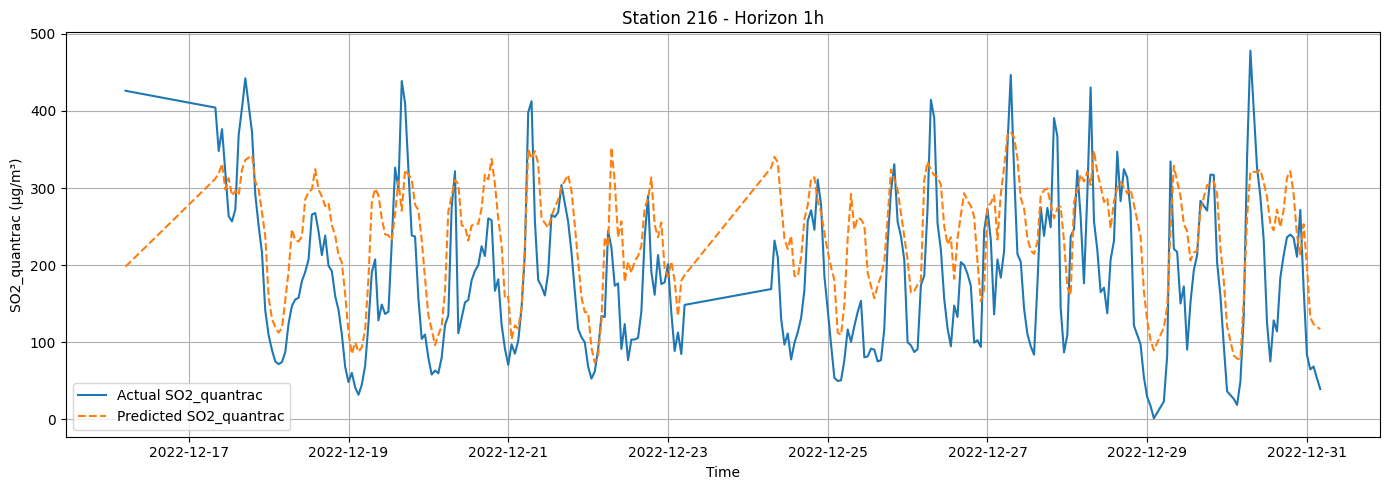

hour = 24


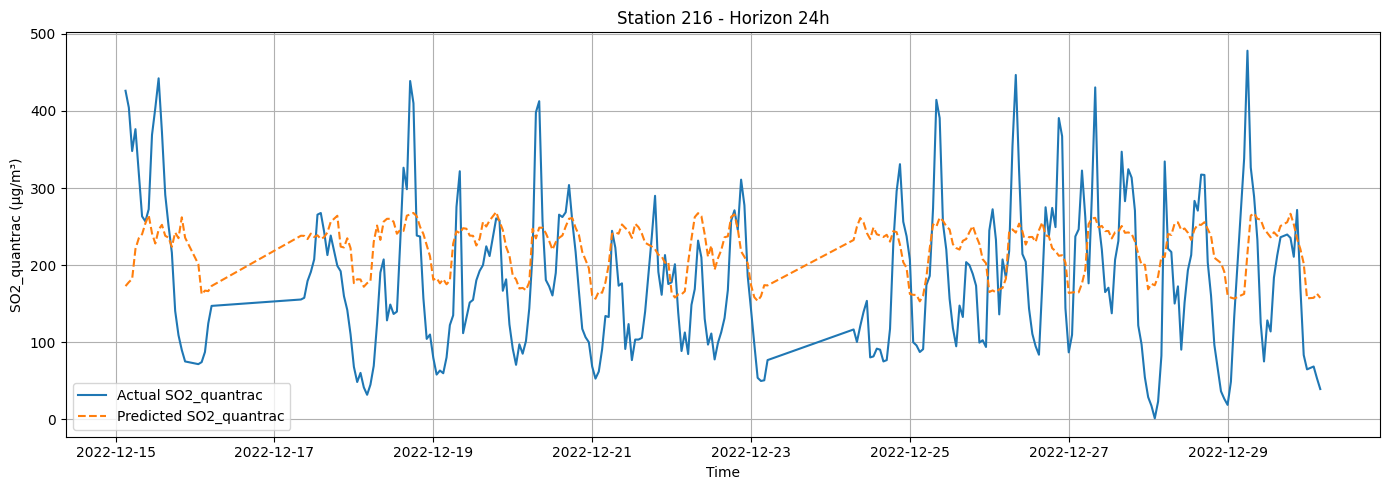

hour = 48


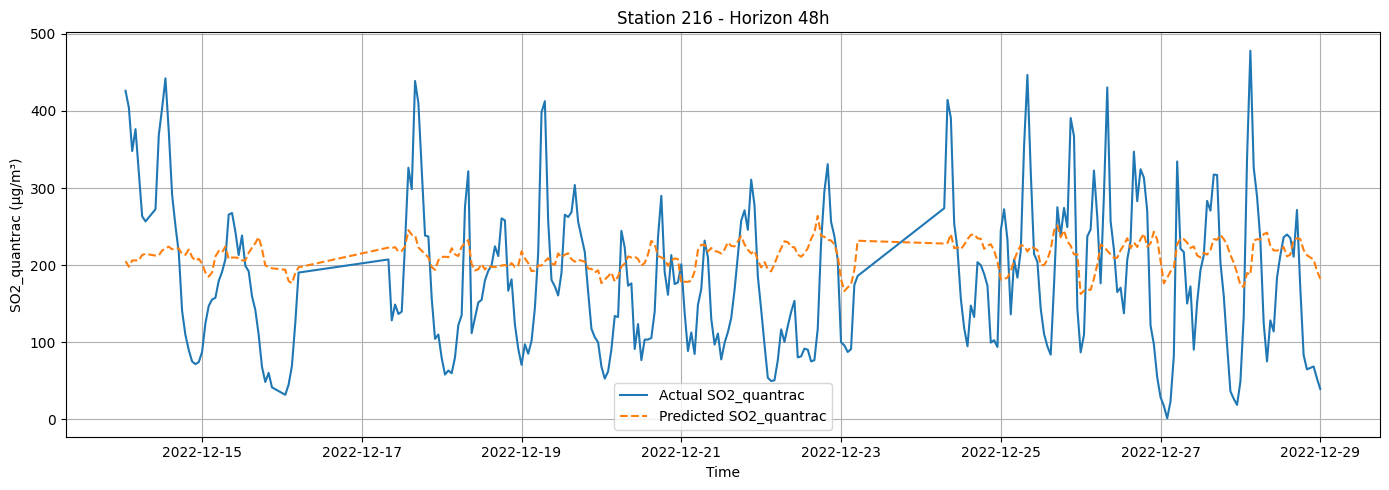

hour = 72


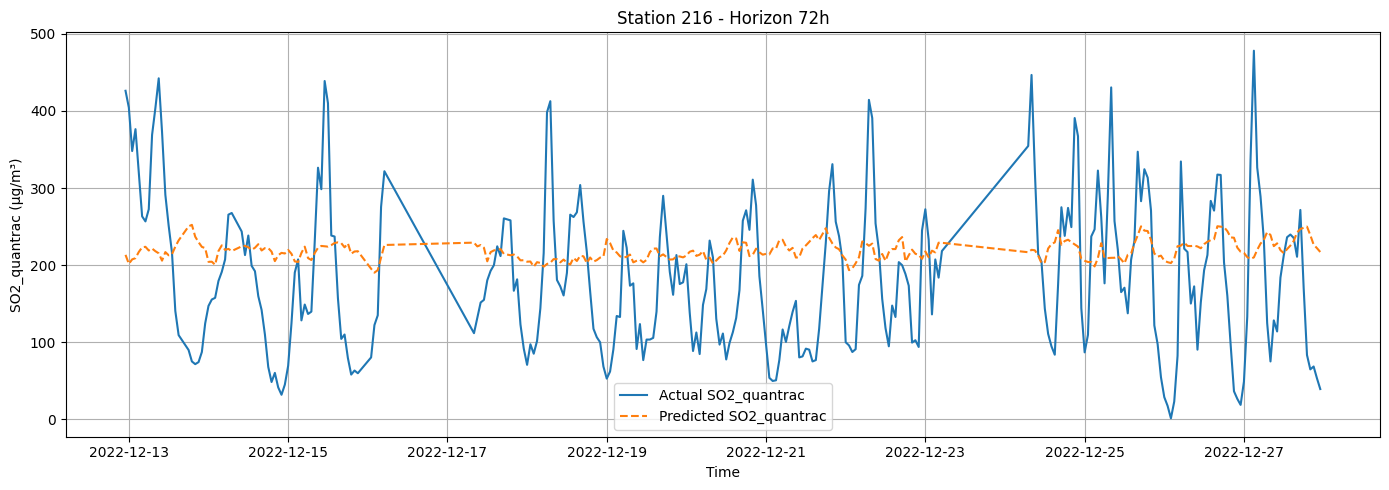

In [19]:
# Reference
for station_id in STATION_IDS:
    print(f"station_id = {station_id}")
    for hour in HORIZONS:
        print(f"hour = {hour}")
        plot_timeseries_example(df_so2, so2_models_by_h[hour], horizon_h=hour, station_id=station_id, target_col=label, LIGHTGBM_DIR=LIGHTGBM_DIR)